In [45]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [46]:
# pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
# pd.set_option('display.width', )
pd.set_option('display.max_colwidth', None)

# set matplotlib style
# plt.style.use('seaborn-whitegrid')
# set font styles and size
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 12

# set seaborn style
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

# set seaborn color palette
sns.set_palette('colorblind')

In [49]:
name_map = {
    'Llama-2-7b-hf': 'Llama-2 (base)',
    # 'llama_2_7b_hf_mono_merged': 'Mono',
    'llama_2_7b_hf_ml1_merged': 'Llama-2 Mono',
    'llama_2_7b_hf_ml2_merged': 'Llama-2 Multi-2',
    'llama_2_7b_hf_ml3_merged': 'Llama-2 Multi-3',
    'llama_2_7b_hf_ml4_merged': 'Llama-2 Multi-4',
    'llama_2_7b_hf_ml5_merged': 'Llama-2 Multi-5',
    # 'llama_2_7b_hf_en_merged': 'Multi-6/en',
    'llama_2_7b_hf_es_merged': 'Llama-2 Multi-6/es',
    'llama_2_7b_hf_ru_merged': 'Llama-2 Multi-6/ru',
    'llama_2_7b_hf_de_merged': 'Llama-2 Multi-6/de',
    'llama_2_7b_hf_zh_merged': 'Llama-2 Multi-6/zh',
    'llama_2_7b_hf_fr_merged': 'Llama-2 Multi-6/fr',
    'llama_2_7b_hf_ca_merged': 'Llama-2 Multi-6/ca',
    'llama_2_7b_hf_mt_es_merged': 'Llama-2 MT Multi-6/es', # translated training data
    'llama_2_7b_hf_mt_ru_merged': 'Llama-2 MT Multi-6/ru', # translated training data
    'llama_2_7b_hf_mt_de_merged': 'Llama-2 MT Multi-6/de', # translated training data
    'llama_2_7b_hf_mt_zh_merged': 'Llama-2 MT Multi-6/zh', # translated training data
    'llama_2_7b_hf_mtol_de_merged': 'Llama-2 MTOL Multi-6/de', # translated training data
    'llama_2_7b_hf_mtol_ca_merged': 'Llama-2 MTOL Multi-6/ca', # translated training data
    'llama_2_7b_hf_mt_ml2_merged': 'Llama-2 MT Multi-2', # translated training data
    'llama_2_7b_hf_mt_ml3_merged': 'Llama-2 MT Multi-3', # translated training data
    'llama_2_7b_hf_mt_ml4_merged': 'Llama-2 MT Multi-4', # translated training data
    'llama_2_7b_hf_mt_ml5_merged': 'Llama-2 MT Multi-5', # translated training data
    'llama_2_7b_hf_mt_ml6_merged': 'Llama-2 MT Multi-6', # translated training data
    'llama_2_7b_hf_guanaco_merged': 'Llama-2 Multi-Guanaco',
    'falcon_7b_ml1_merged': 'Falcon Mono',
    'falcon_7b_ml2_merged': 'Falcon Multi-2',
    'falcon_7b_ml3_merged': 'Falcon Multi-3',
    'falcon_7b_ml4_merged': 'Falcon Multi-4',
    'falcon_7b_ml5_merged': 'Falcon Multi-5',
    'falcon_7b_es_merged': 'Falcon Multi-6/es',
    'falcon_7b_ru_merged': 'Falcon Multi-6/ru',
    'falcon_7b_de_merged': 'Falcon Multi-6/de',
    'falcon_7b_zh_merged': 'Falcon Multi-6/zh',
    'falcon_7b_fr_merged': 'Falcon Multi-6/fr',
    'falcon_7b_ca_merged': 'Falcon Multi-6/ca',
    'falcon_7b_guanaco_merged': 'Falcon Multi-Guanaco',
    'llama_2_70b_hf_mt_ml1_merged': 'Llama-2 70B Mono', 
    'llama_2_70b_hf_mt_ml2_merged': 'Llama-2 70B MT Multi-2', # translated training data
    'llama_2_70b_hf_mt_ml3_merged': 'Llama-2 70B MT Multi-3', # translated training data
    'llama_2_70b_hf_mt_ml4_merged': 'Llama-2 70B MT Multi-4', # translated training data
    'llama_2_70b_hf_mt_ml5_merged': 'Llama-2 70B MT Multi-5', # translated training data
    'llama_2_70b_hf_mt_ml6_merged': 'Llama-2 70B MT Multi-6', # translated training data
    'llama_2_70b_hf_guanaco_merged': 'Llama-2 70B Multi-Guanaco', # translated training data
    'alpaca_eval_instructions_en': 'en',
    'alpaca_eval_instructions_es': 'es',
    'alpaca_eval_instructions_ru': 'ru',
    'alpaca_eval_instructions_de': 'de',
    'alpaca_eval_instructions_zh': 'zh',
    'alpaca_eval_instructions_fr': 'fr',
    'alpaca_eval_instructions_ca': 'ca',
    'alpaca_eval_instructions_sv': 'sv',
    'alpaca_eval_instructions_bg': 'bg',
    'alpaca_eval_instructions_no': 'no',
    'alpaca_eval_instructions_da': 'da*',
    'alpaca_eval_instructions_is': 'is*',
    'alpaca_eval_instructions_hi': 'hi*',
    'alpaca_eval_instructions_el': 'el*',
    'flores_devtest_en_es': 'es',
    'flores_devtest_en_ru': 'ru',
    'flores_devtest_en_de': 'de',
    'flores_devtest_en_zh': 'zh',
    'flores_devtest_en_fr': 'fr',
    'flores_devtest_en_ca': 'ca',
    'flores_devtest_en_sv': 'sv',
    'flores_devtest_en_bg': 'bg',
    'flores_devtest_en_no': 'no',
    'flores_devtest_en_da': 'da*',
    'flores_devtest_en_is': 'is*',
    'flores_devtest_en_hi': 'hi*',
    'flores_devtest_en_el': 'el*',
    'xcsqa_dev_en_en': 'en:en',
    'xcsqa_dev_en_es': 'en:es',
    'xcsqa_dev_en_ru': 'en:ru',
    'xcsqa_dev_en_de': 'en:de',
    'xcsqa_dev_en_fr': 'en:fr',
    'xcsqa_dev_en_hi': 'en:hi*',
    'xcsqa_dev_es_es': 'es:es',
    'xcsqa_dev_ru_ru': 'ru:ru',
    'xcsqa_dev_de_de': 'de:de',
    'xcsqa_dev_fr_fr': 'fr:fr',
    'xcsqa_dev_hi_hi': 'hi*:hi*',
    'xquad_dev_en_en': 'en:en',
    'xquad_dev_en_es': 'en:es',
    'xquad_dev_en_ru': 'en:ru',
    'xquad_dev_en_de': 'en:de',
    'xquad_dev_en_zh': 'en:zh',
    'xquad_dev_en_el': 'en:el*',
    'xquad_dev_en_ar': 'en:ar*',
    'xquad_dev_en_tr': 'en:tr*',
    'xquad_dev_en_vi': 'en:vi*',
    'xquad_dev_en_th': 'en:th*',
    'xquad_dev_es_es': 'es:es',
    'xquad_dev_ru_ru': 'ru:ru',
    'xquad_dev_de_de': 'de:de',
    'xquad_dev_zh_zh': 'zh:zh',
    'xquad_dev_el_el': 'el:el*',
    'xquad_dev_ar_ar': 'ar:ar*', 
    'xquad_dev_tr_tr': 'tr:tr*',
    'xquad_dev_vi_vi': 'vi:vi*',
    'xquad_dev_th_th': 'th:th*',
}

training_langs = {
    'Mono': ['en'],
    'Multi-2': ['en', 'es'],
    'Multi-3': ['en', 'es', 'ru'],
    'Multi-4': ['en', 'es', 'ru', 'de'],
    'Multi-5': ['en', 'es', 'ru', 'de', 'zh'],
    'Multi-6': ['en', 'es', 'ru', 'de', 'zh', 'fr'],
    'Multi-6/de': ['en', 'es', 'ru', 'zh', 'fr', 'ca'],
    'Multi-6/fr': ['en', 'es', 'ru', 'de', 'zh', 'ca'],
    'Multi-6/zh': ['en', 'es', 'ru', 'de', 'fr', 'ca'],
    'Multi-6/es': ['en', 'ru', 'de', 'zh', 'fr', 'ca'],
    'Multi-6/ru': ['en', 'es', 'de', 'zh', 'fr', 'ca'],
    'Multi-6/ca': ['en', 'es', 'ru', 'de', 'zh', 'fr'],
    'Multi-Guanaco': ['es', 'en', 'ru', 'de', 'zh', 'fr', 'ca', 'th', 'pt', 'it', 'uk', 'eu', 'jp', 'pl', 'zh', 'vi', 'hu', 'gn', 'da', 'tr', 'nl', 'gl', 'mt', 'ar', 'ms', 'sc', 'nn', 'ko', 'ht', 'ar', 'id', 'ar', 'wo', 'uz', 'lv', 'jv', 'fi', 'tk', 'tg', 'sv', 'so', 'sl', 'sk', 'no', 'kk', 'ga', 'cz'],
}

def load_json(file):
    with open(file, "r", encoding='utf8') as f:
        return json.load(f)

def parse_filename(file):
    """
    data/outputs/llama_2_7b_hf_en_merged/alpaca_eval_instructions_ru-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.eval
    """
    # get test set and context, allowing for no context
    model_name = Path(file).parent.name
    parts = Path(file).stem.split('-')

    test_set = parts[0]
    context = parts[1]
    prompt = parts[2]
    seed = int(parts[3][1:])
    top_k = int(parts[4][1:])
    top_p = float(parts[5][1:])
    temp = float(parts[6][1:])
    bs = int(parts[7][1:])

    has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = None, None, None, None, None, None
    if len(parts) > 8:

        # with_en-l300-ds42-as42-source_en-system_en
        has_translation = parts[8] == 'with_en'
        n_eval_items = int(parts[-5][1:])
        data_seed = int(parts[-4][2:])
        api_seed = int(parts[-3][2:])
        eval_src = parts[-2]
        eval_tgt = parts[-1]

    return model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt

# sort models given the order in name_map
ordered_model_names = [v for k, v in name_map.items() if k.lower().startswith('llama') or k.lower().startswith('falcon')]
print(ordered_model_names)
ordered_alpaca_test_sets = [v for k, v in name_map.items() if k.startswith('alpaca')]
print(ordered_alpaca_test_sets)
ordered_flores_test_sets = [v for k, v in name_map.items() if k.startswith('flores')]
print(ordered_flores_test_sets)
ordered_xcsr_test_sets = [v for k, v in name_map.items() if k.startswith('xcsqa')]
print(ordered_xcsr_test_sets)
ordered_xquad_test_sets = [v for k, v in name_map.items() if k.startswith('xquad')]
print(ordered_xquad_test_sets)

def apply_sort(df, ordered_test_sets, ordered_model_names=ordered_model_names):

    df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)
    df['test_set'] = pd.Categorical(df['test_set'], ordered_test_sets)

    if 'seed' in df.columns:
        df = df.sort_values(by=['model_name', 'test_set', 'seed'])
    else:
        df = df.sort_values(by=['model_name', 'test_set'])

    # Convert the columns back to their original data types
    df['model_name'] = df['model_name'].astype(str)
    df['test_set'] = df['test_set'].astype(str)
        
    df = df.reset_index(drop=True)

    df.info()
    
    return df


['Llama-2 (base)', 'Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6/es', 'Llama-2 Multi-6/ru', 'Llama-2 Multi-6/de', 'Llama-2 Multi-6/zh', 'Llama-2 Multi-6/fr', 'Llama-2 Multi-6/ca', 'Llama-2 MT Multi-6/es', 'Llama-2 MT Multi-6/ru', 'Llama-2 MT Multi-6/de', 'Llama-2 MT Multi-6/zh', 'Llama-2 MTOL Multi-6/de', 'Llama-2 MTOL Multi-6/ca', 'Llama-2 MT Multi-2', 'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4', 'Llama-2 MT Multi-5', 'Llama-2 MT Multi-6', 'Llama-2 Multi-Guanaco', 'Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6/es', 'Falcon Multi-6/ru', 'Falcon Multi-6/de', 'Falcon Multi-6/zh', 'Falcon Multi-6/fr', 'Falcon Multi-6/ca', 'Falcon Multi-Guanaco', 'Llama-2 70B Mono', 'Llama-2 70B MT Multi-2', 'Llama-2 70B MT Multi-3', 'Llama-2 70B MT Multi-4', 'Llama-2 70B MT Multi-5', 'Llama-2 70B MT Multi-6', 'Llama-2 70B Multi-Guanaco']
['en', 'es', 'ru', 'de', 'zh', 'fr', 'ca', 'sv', 'bg

In [50]:

def get_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for eval_file in Path(results_dir).glob('*/*.eval'):
        # print(eval_file)
        df = pd.read_csv(eval_file, index_col=None)
        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(eval_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
        # # get generation args too
        # try:
        #     hp_file = eval_file.with_suffix(".json")
        #     hps = load_json(hp_file)
        #     eval_dict.update(hps)
        # except:
        #     pass
    
    df = pd.concat(dfs, axis=0, ignore_index=True)

    df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

    # add column for training languages
    df['training_langs'] = df.apply(lambda x: training_langs[x['model_name'].split()[-1]], axis=1)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('training_langs')))
    df = df.reindex(columns=cols)

    df.info()
    
    return df

df = get_results('data/outputs')
print(len(df))
print(df.columns)
df = apply_sort(df, ordered_test_sets=ordered_alpaca_test_sets)
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model_name      1764 non-null   object 
 1   test_set        1764 non-null   object 
 2   seed            1764 non-null   int64  
 3   training_langs  1764 non-null   object 
 4   lang_match      1764 non-null   float64
 5   tgt_lang        1764 non-null   float64
 6   ppl             1344 non-null   float64
 7   file            1764 non-null   object 
 8   context         1764 non-null   object 
 9   ppl_model       846 non-null    object 
 10  n               1509 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 151.7+ KB
1764
Index(['model_name', 'test_set', 'seed', 'training_langs', 'lang_match',
       'tgt_lang', 'ppl', 'file', 'context', 'ppl_model', 'n'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data c

,model_name,test_set,seed,training_langs,lang_match,tgt_lang,ppl,file,context,ppl_model,n
0,Llama-2 Mono,en,0,[en],0.944,0.964,14.927,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
1,Llama-2 Mono,en,42,[en],0.933,0.954,20673.208,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
2,Llama-2 Mono,en,723,[en],0.938,0.960,18.525,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_en-none-guanaco_prompt-s723-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,NaN,NaN
3,Llama-2 Mono,es,0,[en],0.436,0.450,20.300,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_es-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,ai-forever/mGPT,805.0
4,Llama-2 Mono,es,42,[en],0.451,0.467,43.756,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_eval_instructions_es-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8.jsonl,guanaco_prompt,ai-forever/mGPT,805.0


In [51]:
def get_results_overview(df, cols=['model_name', 'test_set', 'seed']):
    for col in cols:
        print(f'*** {col} ***')
        print(df[col].value_counts())
        print()

get_results_overview(df)

*** model_name ***
Llama-2 Mono                 42
Falcon Multi-6/zh            42
Falcon Mono                  42
Falcon Multi-2               42
Falcon Multi-3               42
Falcon Multi-4               42
Falcon Multi-5               42
Falcon Multi-6/es            42
Falcon Multi-6/ru            42
Falcon Multi-6/de            42
Falcon Multi-6/fr            42
Llama-2 Multi-2              42
Falcon Multi-6/ca            42
Falcon Multi-Guanaco         42
Llama-2 70B Mono             42
Llama-2 70B MT Multi-2       42
Llama-2 70B MT Multi-3       42
Llama-2 70B MT Multi-4       42
Llama-2 70B MT Multi-5       42
Llama-2 70B MT Multi-6       42
Llama-2 Multi-Guanaco        42
Llama-2 MT Multi-6           42
Llama-2 MT Multi-5           42
Llama-2 MT Multi-4           42
Llama-2 Multi-3              42
Llama-2 Multi-4              42
Llama-2 Multi-5              42
Llama-2 Multi-6/es           42
Llama-2 Multi-6/ru           42
Llama-2 Multi-6/de           42
Llama-2 Multi-6/zh   

In [52]:
def get_agg_df(
        df, 
        group_cols=['model_name', 'test_set'], 
        agg_ops={
            'lang_match': [np.mean, np.std], 
            'tgt_lang': [np.mean, np.std], 
            'ppl': [np.mean, np.std],
            }
        ):
    """
    Aggregates the results of the different strategies.
    If use_macro is True, then the macro-averaged results are used, otherwise the micro-averaged results are used.
    """
    df = df.groupby(group_cols, as_index=True).agg(agg_ops)
    # df = df.reindex(['0-shot', '1-shot', 'Mem-4', 'Mem-8', 'L2M'])
    # df[df.select_dtypes(include=['number']).columns] *= 100
    df = df.round(2)
    return df

def styled_df(df, color):
    return df.style.background_gradient(axis=0, text_color_threshold=0, cmap=sns.light_palette(color, as_cmap=True)).highlight_max(axis=0, props='font-weight:bold;').format(precision=2)

# unset multi-index
# agg_df = get_agg_df(df).reset_index()
# join levels of multi-index columns
# agg_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in agg_df.columns]
# styled_df(agg_df, 'seagreen')

data/plots/chat_lang_match_llama2_7b_mono_vs_guanaco.png saved.


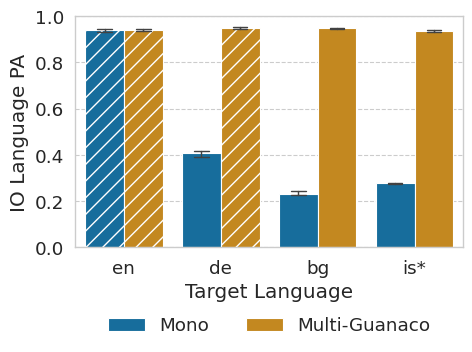

In [61]:
def make_basic_barplot_wide(df, title=None, save_path=None):
    
    # Get the unique values for 'test_set' and 'model_name'
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()

    # number of bars to plot with hue
    expected_num_bars = len(test_sets) * len(model_names)

    width = len(test_sets)
    if len(test_sets) < 6:
        width += 1

    fig, ax = plt.subplots(figsize=(width, 3))

    sns.barplot(data=df,
                x='test_set', y='lang_match', 
                hue='model_name', 
                errorbar=("ci", 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                ax=ax)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
    #         # The index of the bar in the patches list
            index = i * len(model_names) + j
            # only add the first two letters of the test set to capture e.g. sv
            bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')

    if title:
        ax.set_title(title)

    ax.set_xlabel('Target Language')
    ax.set_ylabel('IO Language PA')

    # add horizontal gridlines
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.4)
    ax.set_ylim(0, 1.0)

    # legend at bottom
    if len(test_sets) >= 6:
        ncols = len(model_names)
        y_offset = -0.45
    else:
        ncols = 3
        y_offset = -0.45
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'{save_path} saved.')

    return

# # plot Llama-2 models with incremental multilingual training
# sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6/ca', 'Llama-2 Multi-Guanaco'])]
# sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# # sdf = sdf[sdf['test_set'].isin(['sv', 'da', 'no', 'bg', 'is', 'hi', 'el'])]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '')

# make_basic_barplot_wide(
#     sdf, 
#     # title='IO Language Agreement (avg. 3 inference runs with 95% CI)', 
#     save_path='data/plots/chat_llama2_7b_lang_match_incremental_ml_wide.png')

# # plot Llama-2 models with incremental MT multilingual training
# sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 MT Multi-2', 'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4', 'Llama-2 MT Multi-5', 'Llama-2 MT Multi-6'])]
# sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')

# make_basic_barplot_wide(
#     sdf, 
#     # title='IO Language Agreement (avg. 3 inference runs with 95% CI)', 
#     save_path='data/plots/chat_llama2_7b_lang_match_incremental_mt_ml_wide.png')

# # plot Llama-2 70B models with incremental mt multilingual training
# sdf = df[df['model_name'].isin(['Llama-2 70B Mono', 'Llama-2 70B MT Multi-2', 'Llama-2 70B MT Multi-3', 'Llama-2 70B MT Multi-4', 'Llama-2 70B MT Multi-5', 'Llama-2 70B MT Multi-6'])]
# sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 70B ', '')
# make_basic_barplot_wide(
#     sdf, 
#     # title='IO Language Agreement (avg. 3 inference runs with 95% CI)', 
#     save_path='data/plots/chat_llama2_70b_lang_match_incremental_mt_ml_wide.png'
#     )

# get only Llama-2 models with incremental multilingual training
# en, es, ru, de, zh, fr
# sdf = df[df['model_name'].isin(['Llama-2 Multi-6/es', 'Llama-2 Multi-6/ru', 'Llama-2 Multi-6/de', 'Llama-2 Multi-6/zh', 'Llama-2 Multi-6/fr', 'Llama-2 Multi-6/ca'])]
# # sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
# sdf = sdf[sdf['test_set'].isin(['es', 'ru', 'de', 'zh', 'fr', 'ca'])]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')
# make_basic_barplot_wide(
#     sdf, 
#     # title='IO Language Agreement (avg. 3 inference runs with 95% CI)', 
#     save_path='data/plots/chat_llama2_7b_lang_match_loo_wide.png')

# plot Llama-2 models with incremental multilingual training
sdf = df[df['model_name'].isin([
    'Llama-2 Mono', 
    # 'Llama-2 Multi-6/ca', 
    'Llama-2 Multi-Guanaco'
    ])]
sdf = sdf[sdf['test_set'].isin(['en', 'de', 'bg', 'is*'])]

# sdf = sdf[sdf['test_set'].isin(['sv', 'da', 'no', 'bg', 'is', 'hi', 'el'])]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '')

make_basic_barplot_wide(
    sdf, 
    # title='IO Language Agreement (avg. 3 inference runs with 95% CI)', 
    save_path='data/plots/chat_lang_match_llama2_7b_mono_vs_guanaco.png')


In [85]:
from matplotlib.patches import Rectangle

def make_basic_heatmap(df, metric, include_std=False, title=None, save_path=None, strip_from_model_name=None, include_hatches=False):
        
    models = df['model_name'].unique()
    test_sets = df['test_set'].unique()

    # fig, ax = plt.subplots(figsize=(df.shape[0]*0.2, df.shape[1]*0.8))
    fig, ax = plt.subplots(figsize=(len(test_sets)+1, len(models)+0.2))
    
    heatmap_mean = df.pivot_table(index='model_name', columns='test_set', values=f'{metric}_mean', sort=False)
    heatmap_std = df.pivot_table(index='model_name', columns='test_set', values=f'{metric}_std', sort=False)

    # sort by order in name_map
    heatmap_mean = heatmap_mean.reindex([n for n in ordered_model_names if n in heatmap_mean.index])
    heatmap_std = heatmap_std.reindex([n for n in ordered_model_names if n in heatmap_std.index])

    # sort columns by order in ordered_test_sets
    heatmap_mean = heatmap_mean.reindex(columns=[l for l in ordered_alpaca_test_sets if l in heatmap_mean.columns])
    heatmap_std = heatmap_std.reindex(columns=[l for l in ordered_alpaca_test_sets if l in heatmap_std.columns])

    if strip_from_model_name is not None:
        for segment in strip_from_model_name:
            heatmap_mean.index = heatmap_mean.index.str.replace(segment, '')
            heatmap_std.index = heatmap_std.index.str.replace(segment, '')

    if include_std:
        annotations = heatmap_mean.round(2).astype(str) + "\n± " + heatmap_std.round(2).astype(str)
    else:
        annotations = heatmap_std.round(2).astype(str)

    ax = sns.heatmap(
        heatmap_mean, annot=annotations, fmt='', 
        cmap='Blues', alpha=0.9, cbar=True, 
        cbar_kws={'label': f'IO Language PA', 
                #   'orientation': 'horizontal', 
                  'pad': 0.02,
                  }, 
        vmin=0, vmax=1.0, ax=ax
        )


    highlight_color = 'red'
    if include_hatches:
        # Get the x and y axis labels
        x_labels = heatmap_mean.columns.values
        y_labels = heatmap_mean.index.values

        # Iterate over the cells based on some condition
        for y in range(heatmap_mean.shape[0]):  # for each row
            for x in range(heatmap_mean.shape[1]):  # for each column
                # Check if the cell meets your condition to have hatches
                # Replace 'your_condition' with the actual condition
                if x_labels[x].strip('*') in training_langs[y_labels[y].split()[-1]]:
                    # Add a rectangle with the desired hatch pattern
                    # ax.add_patch(Rectangle((x, y), 1, 1, fill=False, hatch='O.', snap=False))
                    ax.add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor=highlight_color, lw=2))

        
    # reduce font size of annotations
    for t in ax.texts:
        t.set_fontsize(10)
    
    if title:
        ax.set_title(title)

    ax.set_ylabel('Instruction-tuning Data')
    ax.set_xlabel('Target Language')

    # ensure yaxis labels are horizontal
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'{save_path} saved.')

    return

sdf = df[df['model_name'].isin(['Llama-2 Multi-6/es', 'Llama-2 Multi-6/ru', 'Llama-2 Multi-6/de', 'Llama-2 Multi-6/zh', 'Llama-2 Multi-6/fr', 'Llama-2 Multi-6/ca'])]
sdf = sdf[sdf['test_set'].isin(['es', 'de', 'fr', 'ca', 'zh', 'ru'])]

# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    # title='IO Language PA', 
    save_path='data/plots/chat_lang_match_heatmap_llama2_7b_loo.png',
    strip_from_model_name=['Llama-2 ']
    )

sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6/ca'])]
sdf = sdf[sdf['test_set'].isin(['es', 'de', 'fr', 'ca', 'zh', 'ru', 'sv', 'no', 'bg', 'is*', 'hi*', 'el*'])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='', 
    save_path='data/plots/chat_lang_match_heatmap_llama2_7b_incremental.png',
    strip_from_model_name=['Llama-2 ', '/ca'],
    include_hatches=True
    )

sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-6/ca', 'Llama-2 Multi-Guanaco'])]
sdf = sdf[sdf['test_set'].isin(['de', 'zh', 'sv', 'bg', 'is*', 'el*',])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='', 
    save_path='data/plots/chat_lang_match_heatmap_llama2_7b_mono_vs_guanaco.png',
    strip_from_model_name=['Llama-2 ', '/ca'],
    include_hatches=True
    )

sdf = df[df['model_name'].isin(['Falcon Multi-6/de', 'Falcon Multi-6/zh', 'Falcon Multi-6/ru', 'Falcon Multi-6/ca', 'Falcon Multi-6/es', 'Falcon Multi-6/fr'])]
sdf = sdf[sdf['test_set'].isin(['es', 'de', 'fr', 'ca', 'zh', 'ru', 'sv', 'no', 'bg', 'is*', 'hi*', 'el*'])]

# sdf = sdf[sdf['test_set'].isin([ordered_test_sets])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='', 
    save_path='data/plots/chat_lang_match_heatmap_falcon_loo.png',
    strip_from_model_name=['Falcon ']
    )

sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6/ca'])]
sdf = sdf[sdf['test_set'].isin(['es', 'de', 'fr', 'ca', 'zh', 'ru', 'sv', 'no', 'bg', 'is*', 'hi*', 'el*'])]
# aggregate
agg_sdf = get_agg_df(sdf).reset_index()
# join levels of multi-index columns
agg_sdf.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_sdf.columns]

make_basic_heatmap(
    agg_sdf, 
    metric='lang_match',
    include_std=True,
    title='', 
    save_path='data/plots/chat_lang_match_heatmap_falcon_incremental.png',
    strip_from_model_name=['Falcon ', '/ca'],
    include_hatches=True
    )

KeyError: "Column(s) ['lang_match', 'ppl', 'tgt_lang'] do not exist"

# process lm-eval harness results

In [86]:
def load_lm_eval_results_file(file):
    with open(file, "r", encoding='utf8') as f:
        df = pd.DataFrame.from_dict(json.load(f)['results'])
        df['model_name'] = Path(file).stem
        return df

def get_lm_eval_results(results_dir):
    dfs = []
    for results_file in Path(results_dir).glob('*.json'):
        print(results_file)
        df = load_lm_eval_results_file(results_file)
        dfs.append(df)
    df = pd.concat(dfs, axis=0, ignore_index=False).reset_index()
    df = df.rename(columns={'index': 'metric'})

    # Reshape the dataframe, moving model_name and index to the index
    df_long = pd.melt(df, id_vars=['model_name', 'metric'], var_name='task_lang', value_name='score')

    # Split the task_lang into two separate columns for 'task' and 'lang'
    df_long[['task', 'lang']] = df_long['task_lang'].str.split('_', expand=True)

    # Drop the original task_lang column as it's no longer needed
    df_long.drop('task_lang', axis=1, inplace=True)

    # Now pivot to get the 'task', 'lang' and 'index' as part of the column MultiIndex
    df = df_long.pivot_table(index='model_name', columns=['task', 'lang', 'metric'], values='score')

    # # move model_name to front
    # cols = df.columns.tolist()
    # cols.insert(0, cols.pop(cols.index('model_name')))
    # df = df.reindex(columns=cols)
    
    # # split task and lang tags into multiple levels

    # df.set_index(['model_name', 'metric'], inplace=True)
    # df = df.unstack(level='metric')
    
    df.info()

    return df

df = get_lm_eval_results('data/lm_evals')
df

data/lm_evals/llama_2_7b_hf_zh_merged.json
data/lm_evals/llama_2_7b_hf_de_merged.json
data/lm_evals/llama_2_7b_hf_fr_merged.json
data/lm_evals/llama_2_7b_hf_es_merged.json
data/lm_evals/llama_2_7b_hf_ca_merged.json
data/lm_evals/llama_2_7b_hf_ru_merged.json
data/lm_evals/llama_2_7b_hf_ml1_merged.json
data/lm_evals/llama_2_7b_hf_mt_ml2_merged.json
data/lm_evals/llama_2_7b_hf_ml2_merged.json
data/lm_evals/llama_2_7b_hf_mt_ml3_merged.json
data/lm_evals/llama_2_7b_hf_ml3_merged.json
data/lm_evals/llama_2_7b_hf_mt_ml4_merged.json
data/lm_evals/llama_2_7b_hf_ml4_merged.json
data/lm_evals/llama_2_7b_hf_mt_ml5_merged.json
data/lm_evals/llama_2_7b_hf_ml5_merged.json
data/lm_evals/llama_2_7b_hf_mt_ml6_merged.json
data/lm_evals/Llama-2-7b-hf.json
data/lm_evals/llama_2_7b_hf_guanaco_merged.json
data/lm_evals/llama_2_70b_hf_mt_ml1_merged.json
data/lm_evals/llama_2_70b_hf_mt_ml2_merged.json
data/lm_evals/llama_2_70b_hf_mt_ml3_merged.json
data/lm_evals/llama_2_70b_hf_mt_ml5_merged.json
data/lm_evals/

task                           pawsx                                        \
lang                              de                 en                 es   
metric                           acc acc_stderr     acc acc_stderr     acc   
model_name                                                                   
Llama-2-7b-hf                 0.6375   0.010752  0.6860   0.010381  0.6510   
llama_2_70b_hf_mt_ml1_merged  0.6595   0.010599  0.6680   0.010533  0.6395   
llama_2_70b_hf_mt_ml2_merged  0.6685   0.010529  0.6680   0.010533  0.6295   
llama_2_70b_hf_mt_ml3_merged  0.6570   0.010618  0.6820   0.010416  0.6415   
llama_2_70b_hf_mt_ml4_merged  0.6455   0.010699  0.6670   0.010541  0.6380   
llama_2_70b_hf_mt_ml5_merged  0.6350   0.010768  0.6855   0.010385  0.6470   
llama_2_70b_hf_mt_ml6_merged  0.6430   0.010716  0.6760   0.010467  0.6430   
llama_2_7b_hf_ca_merged       0.6485   0.010679  0.6955   0.010293  0.6710   
llama_2_7b_hf_de_merged       0.6465   0.010692  0.6970   0.010279  0.6775   
llama_2_7b_hf_es_merged       0.6480   0.010682  0.6965   0.010283  0.6745   
llama_2_7b_hf_fr_merged       0.6505   0.010665  0.6980   0.010269  0.6735   
llama_2_7b_hf_guanaco_merged  0.6560   0.010625  0.6950   0.010298  0.6750   
llama_2_7b_hf_ml1_merged      0.6430   0.010716  0.6935   0.010312  0.6680   
llama_2_7b_hf_ml2_merged      0.6450   0.010703  0.6950   0.010298  0.6715   
llama_2_7b_hf_ml3_merged      0.6480   0.010682  0.6930   0.010316  0.6710   
llama_2_7b_hf_ml4_merged      0.6490   0.010675  0.6945   0.010302  0.6725   
llama_2_7b_hf_ml5_merged      0.6475   0.010685  0.6955   0.010293  0.6725   
llama_2_7b_hf_mt_ml2_merged   0.6510   0.010661  0.6925   0.010321  0.6770   
llama_2_7b_hf_mt_ml3_merged   0.6555   0.010629  0.6900   0.010344  0.6810   
llama_2_7b_hf_mt_ml4_merged   0.6555   0.010629  0.6915   0.010330  0.6775   
llama_2_7b_hf_mt_ml5_merged   0.6590   0.010603  0.6925   0.010321  0.6750   
llama_2_7b_hf_mt_ml6_merged   0.6610   0.010588  0.6925   0.010321  0.6805   
llama_2_7b_hf_ru_merged       0.6540   0.010639  0.6970   0.010279  0.6740   
llama_2_7b_hf_zh_merged       0.6525   0.010650  0.6965   0.010283  0.6775   

task                                                                           \
lang                                         fr                 ja              
metric                       acc_stderr     acc acc_stderr     acc acc_stderr   
model_name                                                                      
Llama-2-7b-hf                  0.010661  0.5855   0.011018  0.4995   0.011183   
llama_2_70b_hf_mt_ml1_merged   0.010739  0.5810   0.011035  0.5545   0.011117   
llama_2_70b_hf_mt_ml2_merged   0.010802  0.5825   0.011030  0.5475   0.011133   
llama_2_70b_hf_mt_ml3_merged   0.010726  0.5740   0.011060  0.5510   0.011125   
llama_2_70b_hf_mt_ml4_merged   0.010749  0.5855   0.011018  0.5680   0.011079   
llama_2_70b_hf_mt_ml5_merged   0.010689  0.5815   0.011034  0.5395   0.011148   
llama_2_70b_hf_mt_ml6_merged   0.010716  0.5890   0.011005  0.5490   0.011129   
llama_2_7b_hf_ca_merged        0.010509  0.6040   0.010939  0.4995   0.011183   
llama_2_7b_hf_de_merged        0.010455  0.6045   0.010936  0.5025   0.011183   
llama_2_7b_hf_es_merged        0.010480  0.6020   0.010948  0.4980   0.011183   
llama_2_7b_hf_fr_merged        0.010488  0.6040   0.010939  0.4995   0.011183   
llama_2_7b_hf_guanaco_merged   0.010476  0.6000   0.010957  0.4920   0.011182   
llama_2_7b_hf_ml1_merged       0.010533  0.6040   0.010939  0.4975   0.011183   
llama_2_7b_hf_ml2_merged       0.010505  0.6045   0.010936  0.4980   0.011183   
llama_2_7b_hf_ml3_merged       0.010509  0.6060   0.010929  0.4970   0.011183   
llama_2_7b_hf_ml4_merged       0.010497  0.6005   0.010955  0.4945   0.011182   
llama_2_7b_hf_ml5_merged       0.010497  0.6060   0.010929  0.4945   0.011182   
llama_2_7b_hf_mt_ml2_merged    0.010459  0.6165   0.010875  0.4925   0.011182   
llama_2_7b_hf_mt_ml3_merged    0.

In [87]:
def process_single_dataset_df(df):

    # multiply all numeric values by 100
    df[df.select_dtypes(include=['number']).columns] *= 100
    # round all numeric values to 2 decimal places
    df = df.round(2)

    # get the list of langs in dataframe from the multi-index
    langs = df.columns.get_level_values(0).unique().tolist()
    
    for lang in langs:
        acc_col = (lang, 'acc')
        stderr_col = (lang, 'acc_stderr') 
        df[lang] = df[acc_col].astype(str) + ' ± ' + df[stderr_col].astype(str)

    # drop all acc_stderr columns from multi-index
    df.drop(df.filter(like='acc_stderr').columns, axis=1, inplace=True)

    # drop 'metric' level from multi-index
    df.columns = df.columns.droplevel(level=1)

    # drop model_name as index
    df.reset_index(inplace=True)

    df.replace({'model_name': name_map}, inplace=True)

    print(df['model_name'].unique())

    # # sort rows by model_name in name_map
    df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)
    df = df.sort_values(by=['model_name'])
    # # Convert the columns back to their original data types
    df['model_name'] = df['model_name'].astype(str)
    
    # subscript the stderror values in each cell
    # df = df.style.format(lambda x: x.replace('±', '\pm '))

    return df
print('\nPAWS-X\n')
print(process_single_dataset_df(df['pawsx']).to_latex(index=False))
print('\nXNLI\n')
print(process_single_dataset_df(df['xnli']).to_latex(index=False))
print('\nX-Winograd\n')
print(process_single_dataset_df(df['xwinograd']).to_latex(index=False))



PAWS-X

['Llama-2 (base)' 'Llama-2 70B Mono' 'Llama-2 70B MT Multi-2'
 'Llama-2 70B MT Multi-3' 'Llama-2 70B MT Multi-4'
 'Llama-2 70B MT Multi-5' 'Llama-2 70B MT Multi-6' 'Llama-2 Multi-6/ca'
 'Llama-2 Multi-6/de' 'Llama-2 Multi-6/es' 'Llama-2 Multi-6/fr'
 'Llama-2 Multi-Guanaco' 'Llama-2 Mono' 'Llama-2 Multi-2'
 'Llama-2 Multi-3' 'Llama-2 Multi-4' 'Llama-2 Multi-5'
 'Llama-2 MT Multi-2' 'Llama-2 MT Multi-3' 'Llama-2 MT Multi-4'
 'Llama-2 MT Multi-5' 'Llama-2 MT Multi-6' 'Llama-2 Multi-6/ru'
 'Llama-2 Multi-6/zh']
\begin{tabular}{llllllll}
\toprule
            model\_name &           de &           en &           es &           fr &           ja &           ko &           zh \\
\midrule
        Llama-2 (base) & 63.75 ± 1.08 &  68.6 ± 1.04 &  65.1 ± 1.07 &  58.55 ± 1.1 & 49.95 ± 1.12 &  52.0 ± 1.12 &  58.05 ± 1.1 \\
          Llama-2 Mono &  64.3 ± 1.07 & 69.35 ± 1.03 &  66.8 ± 1.05 &  60.4 ± 1.09 & 49.75 ± 1.12 & 51.15 ± 1.12 &   59.2 ± 1.1 \\
       Llama-2 Multi-2 &  64.5 ± 1.07 & 

/tmp/ipykernel_4117202/2999050585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.select_dtypes(include=['number']).columns] *= 100
/tmp/ipykernel_4117202/2999050585.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(process_single_dataset_df(df['pawsx']).to_latex(index=False))
/tmp/ipykernel_4117202/2999050585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   test_set    63 non-null     object 
 1   model_name  63 non-null     object 
 2   acc         63 non-null     float64
 3   stderr      63 non-null     float64
 4   lower_ci    63 non-null     float64
 5   upper_ci    63 non-null     float64
dtypes: float64(4), object(2)
memory usage: 3.1+ KB
saved to data/plots/xnli_llama2_7b_incremental.png


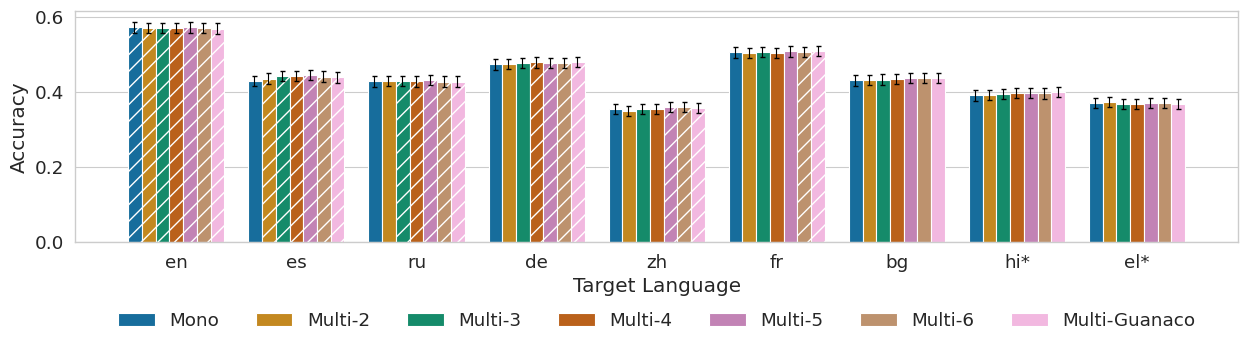

In [88]:
def plot_single_dataset_df(df, title=None, save_path=None):

    # df['ci_size'] = df['upper_ci'] - df['lower_ci']
    yerr = [df['acc'] - df['lower_ci'], df['upper_ci'] - df['acc']]

    # get the list of langs in dataframe from the multi-index
    test_sets = df['test_set'].unique().tolist()
    model_names = df['model_name'].unique().tolist()
    
    # # Get the positions of the bars in the barplot
    # x_values = []
    # for test in test_sets:
    #     for i, model in enumerate(model_names):
    #         x_values.append(test_sets.index(test) + i * 0.2 - 0.1)

    fig, ax = plt.subplots(figsize=(15, 3))

    ax = sns.barplot(data=df,
                x='test_set', 
                y='acc', 
                hue='model_name', 
                # errorbar=("ci", 95), capsize=0.3,
                # err_kws={"linewidth": 1.0},
                alpha=1.0,
                # hue_order=ordered_test_sets,
                ax=ax
                )

    # Iterate over each unique test_set and model_name to place the error bars
    for test_set in df['test_set'].unique():
        for model_name in df['model_name'].unique():
            subset = df[(df['test_set'] == test_set) & (df['model_name'] == model_name)]
            if not subset.empty:
                row = subset.iloc[0]
                x = ax.get_xticks()[list(df['test_set'].unique()).index(test_set)]
                hue_offset = 0.115 * list(df['model_name'].unique()).index(model_name) - 0.35
                plt.errorbar(x=x + hue_offset, y=row['acc'], 
                             yerr=[[row['acc'] - row['lower_ci']], [row['upper_ci'] - row['acc']]], 
                             fmt='none', c='black', 
                             linewidth=0.8,
                             capsize=1.8
                             )

    # put legend outside of plot at bottom
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=6)


   # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
            # The index of the bar in the patches list
            index = i * len(model_names) + j
            # only add the first two letters of the test set to capture e.g. sv
            bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')

    ax.set_xlabel('Target Language')
    ax.set_ylabel('Accuracy')
    
    # fix ylim to 1-6
    # ax.set_ylim(0.5, 4.5)

    ax.set_title(title)

    # legend at bottom
    if len(test_sets) >= 6:
        ncols = len(model_names)
        y_offset = -0.45
    else:
        ncols = 3
        y_offset = -0.55

    # add custom legend
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')


    return

def calculate_95_confidence_intervals(data):
    """
    Adds 95% confidence intervals to the dataset.

    Args:
    data (pd.DataFrame): A DataFrame containing the columns 'acc', 'acc_stderr'.
    
    Returns:
    pd.DataFrame: Original DataFrame with two new columns 'lower_ci' and 'upper_ci'.
    """
    z_score = 1.96  # Z-score for 95% confidence

    # Calculating the confidence intervals
    data['lower_ci'] = data['acc'] - z_score * data['stderr']
    data['upper_ci'] = data['acc'] + z_score * data['stderr']

    return data

def format_dataframe_to_plot(df, dataset_name):

    # print(plot_single_dataset_df(df['pawsx'].unstack(level=0).reset_index()))
    df = df[dataset_name].unstack(level=0).reset_index().rename(columns={0: 'value'})
    # rename model_name using name_map
    df.replace({'model_name': name_map}, inplace=True)

    acc_df = df[df['metric'] == 'acc']
    stderr_df = df[df['metric'] == 'acc_stderr']

    # Merge the dataframes on language and model name
    df = pd.merge(acc_df, stderr_df, on=['lang', 'model_name'])
    df.rename(columns={'value_x': 'acc', 'value_y': 'stderr', 'lang': 'test_set'}, inplace=True)
    df.drop(['metric_x', 'metric_y'], axis=1, inplace=True)

    # rename el to el*
    df['test_set'] = df['test_set'].str.replace('el', 'el*')
    df['test_set'] = df['test_set'].str.replace('hi', 'hi*')
    

    return calculate_95_confidence_intervals(df)

sdf = format_dataframe_to_plot(df, 'xnli')
sdf = sdf[sdf['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6/ca', 'Llama-2 Multi-Guanaco'])]
sdf = apply_sort(sdf, ordered_test_sets=ordered_alpaca_test_sets)
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '')
# sdf[sdf['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2'])].to_csv('scratch/xnli_sample.csv')
sdf

plot_single_dataset_df(sdf, save_path='data/plots/xnli_llama2_7b_incremental.png')


# LLM Judge Results

In [89]:
def get_llm_judge_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for llm_eval_file in sorted(Path(results_dir).glob('*/*.jsonl')):
        # print(llm_eval_file)
        df = pd.read_json(llm_eval_file, lines=True)

        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(llm_eval_file)
        
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        df['n_eval_items'] = n_eval_items
        df['data_seed'] = data_seed
        df['api_seed'] = api_seed
        df['eval_src'] = eval_src
        df['eval_tgt'] = eval_tgt

        dfs.append(df)
            
    print(f'Gathered {len(dfs)} dataframes.')
    df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('eval_src')))
    cols.insert(4, cols.pop(cols.index('eval_tgt')))
    print(cols)
    df = df.reindex(columns=cols)

    return df

df = get_llm_judge_results('data/llm_evals/likert/gpt-3.5-turbo-1106')
print(len(df))

# inspect rows with NaN values in eval_score
# df[df['eval_score'].isna()]
# df[df['eval_score'] == 0]

# drop rows containing isna values in eval_score
df = df.dropna(subset=['eval_score'])
print(len(df))

# drop rows where eval_score is not between 1 and 6
df = df[(df['eval_score'] >= 1) & (df['eval_score'] <= 6)]
print(len(df))

# if 'system_lang' does not match 'source_lang', then set 'eval_score' to 1
df.loc[df['system_lang'] != df['source_lang'], 'eval_score'] = 1

# rename values according to name_map
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

# discard column with name "eval_Should I leave him. How do I like it?" - occurs once due to parsing errors from jsonl object returned from llm
# data/llm_evals/likert/gpt-3.5-turbo-1106/llama_2_7b_hf_ca_merged/alpaca_eval_instructions_el-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8-with_en-l300-ds42-as42-source_en-system_en.jsonl
df = df.drop(columns=['eval_Should I leave him. How do I like it?'])

df = apply_sort(df, ordered_test_sets=ordered_alpaca_test_sets)

# inspect total tokens from eval_meta
eval_costs = []
for i, row in df.iterrows():
    # eval_tokens.append(row['eval_meta']['prompt_tokens'] + row['eval_meta']['completion_tokens'])
    cost = row['eval_meta']['cost']
    if isinstance(row['translation_meta'], dict):
        cost += row['translation_meta']['cost']
    eval_costs.append(cost)

print(len(df))
print(len(eval_costs))
print(np.mean(eval_costs))
print(max(eval_costs))
print(min(eval_costs))
print(sum(eval_costs))

# drop columns: eval_meta, translation_meta, prompt, source, system
df = df.drop(columns=['eval_meta', 'translation_meta', 'prompt', 'source', 'system', 'source_en', 'system_en', 'eval_reasoning'])
len(df)

# check that for each model, the same ids are evaluated
all_ids = set()
for model_name in df['model_name'].unique():
    ids = df[df['model_name'] == model_name]['id'].unique()
    all_ids.update(ids)
print(len(all_ids))

df.info()

Gathered 1095 dataframes.
['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt', 'prompt', 'system', 'finish_reason', 'source', 'secs', 'source_lang', 'system_lang', 'id', 'eval_reasoning', 'eval_score', 'eval_meta', 'context', 'n_eval_items', 'data_seed', 'api_seed', 'eval_Pizzeria,', 'source_en', 'system_en', 'translation_meta', 'eval_Should I leave him. How do I like it?']
328500
328404
328138
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328138 entries, 0 to 328137
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   model_name        328138 non-null  object 
 1   test_set          328138 non-null  object 
 2   seed              328138 non-null  int64  
 3   eval_src          328138 non-null  object 
 4   eval_tgt          328138 non-null  object 
 5   prompt            328138 non-null  object 
 6   system            328138 non-null  object 
 7   finish_reason     328138 non-null  object 
 8   

In [90]:
# # aggregate score by model_name, test_set, seed
# agg_df = df[df['eval_src'] == 'source'].groupby(['model_name', 'test_set'], as_index=False).agg({'eval_score': [np.mean, np.std]})
# agg_df

# # aggregate score by model_name, test_set, seed
# agg_df = df[df['eval_src'] == 'source_en'].groupby(['model_name', 'test_set'], as_index=False).agg({'eval_score': [np.mean, np.std]})
# agg_df


In [91]:
print(df['model_name'].value_counts())
print(df['eval_src'].value_counts())
print(df['eval_tgt'].value_counts())
print(df['eval_score'].value_counts())
print(df['test_set'].value_counts())
print(df['id'].value_counts())

Llama-2 Multi-6/ca           22472
Llama-2 Multi-Guanaco        11697
Falcon Multi-Guanaco         11696
Llama-2 Multi-5              11694
Falcon Multi-6/ca            11692
Llama-2 MT Multi-6           11691
Llama-2 MT Multi-3           11690
Falcon Multi-5               11690
Falcon Mono                  11689
Llama-2 MT Multi-5           11689
Llama-2 MT Multi-2           11689
Llama-2 70B Mono             11688
Llama-2 Multi-2              11688
Llama-2 Mono                 11688
Llama-2 Multi-3              11687
Llama-2 70B MT Multi-4       11685
Llama-2 70B MT Multi-3       11685
Llama-2 Multi-4              11685
Llama-2 MT Multi-4           11684
Llama-2 70B MT Multi-5       11684
Falcon Multi-2               11684
Falcon Multi-3               11682
Falcon Multi-4               11679
Llama-2 70B MT Multi-2       11676
Llama-2 70B MT Multi-6       11674
Llama-2 70B Multi-Guanaco     9891
Llama-2 MTOL Multi-6/ca       3596
Llama-2 Multi-6/de            2699
Llama-2 Multi-6/zh  

In [92]:
df.head()

,model_name,test_set,seed,eval_src,eval_tgt,finish_reason,secs,source_lang,system_lang,id,eval_score,context,n_eval_items,data_seed,api_seed,"eval_Pizzeria,"
0,Llama-2 Mono,en,0,source,system,stop,0.793132,eng_Latn,eng_Latn,192,5.0,guanaco_prompt,300,42,42,NaN
1,Llama-2 Mono,en,0,source,system,stop,1.108659,eng_Latn,eng_Latn,718,6.0,guanaco_prompt,300,42,42,NaN
2,Llama-2 Mono,en,0,source,system,stop,2.605155,eng_Latn,eng_Latn,168,3.0,guanaco_prompt,300,42,42,NaN
3,Llama-2 Mono,en,0,source,system,stop,1.376305,eng_Latn,eng_Latn,522,4.0,guanaco_prompt,300,42,42,NaN
4,Llama-2 Mono,en,0,source,system,stop,0.841068,eng_Latn,eng_Latn,536,5.0,guanaco_prompt,300,42,42,NaN


In [93]:
# set pandas settings to display more rows
pd.set_option('display.max_rows', 50)
df['model_name'].value_counts()

Llama-2 Multi-6/ca           22472
Llama-2 Multi-Guanaco        11697
Falcon Multi-Guanaco         11696
Llama-2 Multi-5              11694
Falcon Multi-6/ca            11692
Llama-2 MT Multi-6           11691
Llama-2 MT Multi-3           11690
Falcon Multi-5               11690
Falcon Mono                  11689
Llama-2 MT Multi-5           11689
Llama-2 MT Multi-2           11689
Llama-2 70B Mono             11688
Llama-2 Multi-2              11688
Llama-2 Mono                 11688
Llama-2 Multi-3              11687
Llama-2 70B MT Multi-4       11685
Llama-2 70B MT Multi-3       11685
Llama-2 Multi-4              11685
Llama-2 MT Multi-4           11684
Llama-2 70B MT Multi-5       11684
Falcon Multi-2               11684
Falcon Multi-3               11682
Falcon Multi-4               11679
Llama-2 70B MT Multi-2       11676
Llama-2 70B MT Multi-6       11674
Llama-2 70B Multi-Guanaco     9891
Llama-2 MTOL Multi-6/ca       3596
Llama-2 Multi-6/de            2699
Llama-2 Multi-6/zh  

['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']
saved to data/plots/chat_llm_judge_llama_7b_incremental.png


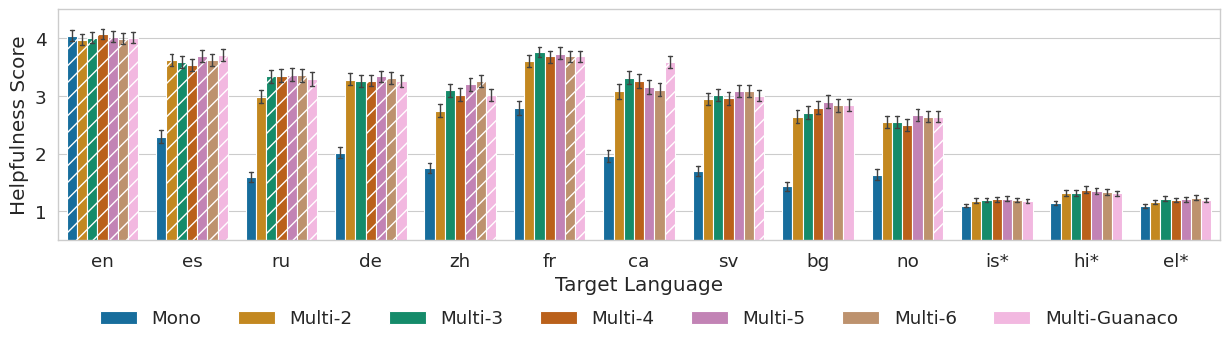

In [94]:

def plot_llm_judge_score_distribution(df, title=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 3))
    
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(model_names)
    # sns.boxplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    # sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95), capsize=0.3,
                # errorbar='sd', capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                )
        
    # apply hatches to certain bars
    # for p in ax.patches:
    #     print(p)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
            # The index of the bar in the patches list
            index = i * len(model_names) + j
            # only add the first two letters of the test set to capture e.g. sv
            bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')

    
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Helpfulness Score')
    
    # fix ylim to 1-6
    ax.set_ylim(0.5, 4.5)

    ax.set_title(title)

    # legend at bottom
    if len(test_sets) >= 6:
        ncols = len(model_names)
        y_offset = -0.45
    else:
        ncols = 3
        y_offset = -0.55
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return


sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6/ca', 'Llama-2 Multi-Guanaco'])]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '')

plot_llm_judge_score_distribution(
    sdf, 
    # title='Llama-7b Evaluation (evaluated in x)',
    save_path='data/plots/chat_llm_judge_llama_7b_incremental.png'
    )

# sdf = df[df['model_name'].isin(['Llama-2 Multi-6/es', 'Llama-2 Multi-6/ru', 'Llama-2 Multi-6/de', 'Llama-2 Multi-6/zh', 'Llama-2 Multi-6/fr', 'Llama-2 Multi-6/ca'])]
# sdf = sdf[sdf['test_set'].isin(['es', 'ru', 'de', 'zh', 'fr', 'ca'])]
# sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')

# plot_llm_judge_score_distribution(
#     sdf, 
#     # title='Llama-7b Evaluation (evaluated in x)',
#     save_path='data/plots/chat_llm_judge_llama_7b_loo.png'
#     )

MT Multi-6    11691
MT Multi-3    11690
MT Multi-2    11689
MT Multi-5    11689
Mono          11688
MT Multi-4    11684
Name: model_name, dtype: int64
['Mono' 'MT Multi-2' 'MT Multi-3' 'MT Multi-4' 'MT Multi-5' 'MT Multi-6']
saved to data/plots/chat_llm_judge_llama_7b_incremental_mt.png


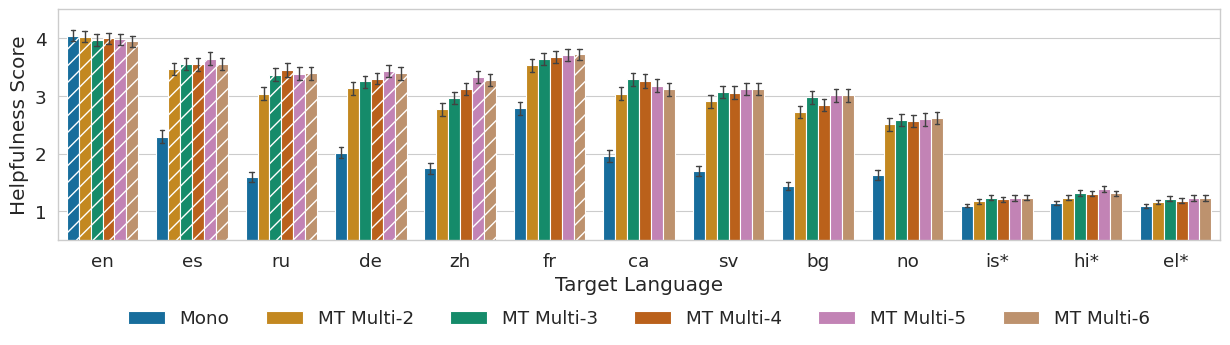

In [95]:
sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 MT Multi-2', 'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4', 'Llama-2 MT Multi-5', 'Llama-2 MT Multi-6'])]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2', '').str.strip()
# print(len(sdf))
print(sdf['model_name'].value_counts())
plot_llm_judge_score_distribution(
    sdf, 
    # title='Llama-7b MT ML Evaluation (evaluated in x)',
    save_path='data/plots/chat_llm_judge_llama_7b_incremental_mt.png'
    )


Mono          11688
MT Multi-3    11685
MT Multi-4    11685
MT Multi-5    11684
MT Multi-2    11676
MT Multi-6    11674
Name: model_name, dtype: int64
['Mono' 'MT Multi-2' 'MT Multi-3' 'MT Multi-4' 'MT Multi-5' 'MT Multi-6']
saved to data/plots/chat_llm_judge_llama_70b_incremental_mt.png


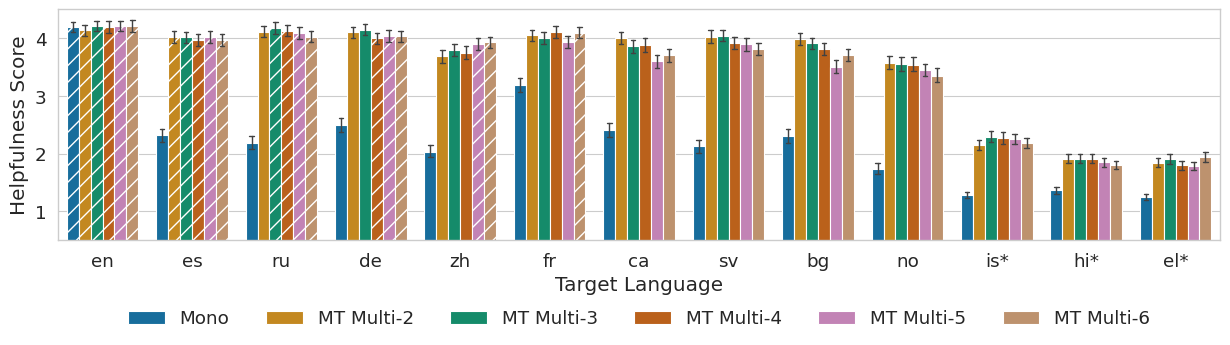

In [96]:
sdf = df[df['model_name'].isin(['Llama-2 70B Mono', 'Llama-2 70B MT Multi-2', 'Llama-2 70B MT Multi-3', 'Llama-2 70B MT Multi-4', 'Llama-2 70B MT Multi-5', 'Llama-2 70B MT Multi-6'])]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 70B', '').replace('MT', '').str.strip()
# print(len(sdf))
print(sdf['model_name'].value_counts())
plot_llm_judge_score_distribution(
    sdf, 
    # title='Llama-70b MT ML Evaluation (evaluated in x)',
    save_path='data/plots/chat_llm_judge_llama_70b_incremental_mt.png'
    )


In [97]:
# sdf = df[df['model_name'].isin(['Llama-2 MTOL Multi-6/ca'])]
# sdf = sdf[sdf['test_set'].isin(ordered_test_sets)]
# # sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
# # sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 70B', '')
# # print(len(sdf))
# print(sdf['model_name'].value_counts())
# plot_score_distribution(
#     sdf, 
#     title='Llama-70b Evaluation (evaluated in x)',
#     save_path='data/plots/llm_judge_7b_incremental_ml_mtol_wide.png'
#     )

81812
Multi-Guanaco    11696
Multi-6          11692
Multi-5          11690
Mono             11689
Multi-2          11684
Multi-3          11682
Multi-4          11679
Name: model_name, dtype: int64
['Mono' 'Multi-2' 'Multi-3' 'Multi-4' 'Multi-5' 'Multi-6' 'Multi-Guanaco']
saved to data/plots/chat_llm_judge_falcon_7b_incremental.png


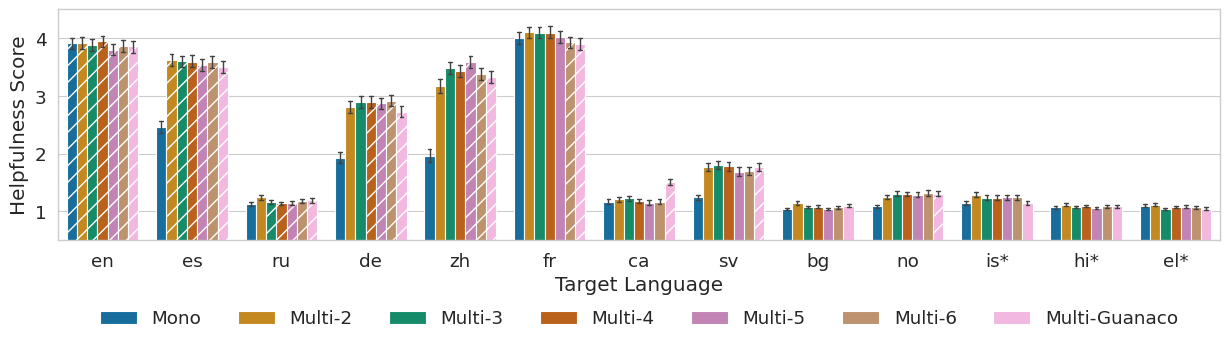

In [98]:
sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6/ca', 'Falcon Multi-Guanaco'])]
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]
sdf = sdf[ (sdf['eval_src'] == 'source') & (sdf['eval_tgt'] == 'system') ]
sdf['model_name'] = sdf['model_name'].str.replace('Falcon', '').str.replace('/ca', '').str.strip()
print(len(sdf))
print(sdf['model_name'].value_counts())
plot_llm_judge_score_distribution(
    sdf, 
    # title='Falcon-7b ML Evaluation (evaluated in x)',
    save_path='data/plots/chat_llm_judge_falcon_7b_incremental.png'
    )

70131
70131
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'source_lang', 'system_lang', 'id',
       'eval_score', 'context', 'n_eval_items', 'data_seed', 'api_seed',
       'eval_Pizzeria,'],
      dtype='object')
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'source_lang', 'system_lang', 'id',
       'eval_score', 'context', 'n_eval_items', 'data_seed', 'api_seed',
       'eval_Pizzeria,'],
      dtype='object')
['Mono', 'Multi-2', 'Multi-3', 'Multi-4', 'Multi-5', 'Multi-6']
[<matplotlib.patches.Rectangle object at 0x7fe0321ef1c0>, <matplotlib.patches.Rectangle object at 0x7fe0321eed70>, <matplotlib.patches.Rectangle object at 0x7fe0321ed570>, <matplotlib.patches.Rectangle object at 0x7fdffd76c0a0>, <matplotlib.patches.Rectangle object at 0x7fdffd76c2b0>, <matplotlib.patches.Rectangle object at 0x7fdffd76c4c0>, <matplotlib.lines.Line2D object at 0x7fdfcfb3d7e0>, <matplotlib.lines.Lin

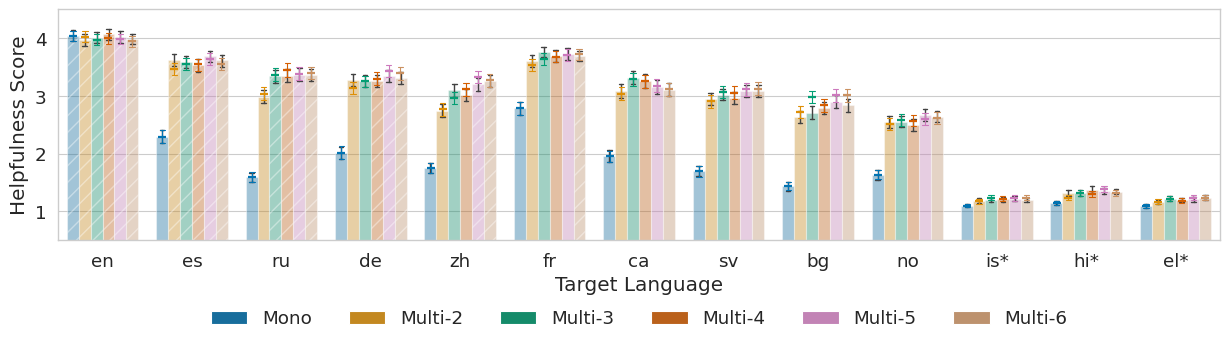

In [102]:
def plot_llm_judge_score_distribution_differences(df1, df2, title=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 3))
    
    test_sets_1 = [l for l in ordered_alpaca_test_sets if l in df1['test_set'].unique()]
    test_sets_2 = [l for l in ordered_alpaca_test_sets if l in df2['test_set'].unique()]

    if test_sets_1 != test_sets_2:
        raise RuntimeError('test sets are not equal!')
        
    model_names_1 = [m for m in df1['model_name'].unique()]
    model_names_2 = [m for m in df2['model_name'].unique()]

    # if model_names_1 != model_names_2:
    #     raise RuntimeError('model names are not equal!')
    
    print(model_names_1)
    
    
    # sns.pointplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,  
    #             errorbar=("ci", 95), capsize=0.1,
    #             # errorbar='sd', capsize=0.3,
    #             err_kws={"linewidth": 0.5},
    #             alpha=0.5,
    #             markers=['o', 'o', 'o', 'o', 'o', 'o', 'o'],
    #             order=test_sets_1,
    #             hue_order=model_names_1,
    #             dodge=0.5,
    #             linestyle='none',
    #             )

    sns.barplot(data=df1, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95), capsize=0.3,
                # errorbar='sd', capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=0.4,
                order=test_sets_1,
                hue_order=model_names_1,
                )
        

    sns.pointplot(data=df2, x='test_set', y='eval_score', hue='model_name', ax=ax,  
                errorbar=("ci", 95), capsize=0.06,
                # errorbar='sd', capsize=0.3,
                err_kws={"linewidth": 0.8},
                alpha=1.0,
                markers=['_', '_', '_', '_', '_', '_', '_'],
                # markers=['x', 'x', 'x', 'x', 'x', 'x', 'x'],
                order=test_sets_2,
                hue_order=model_names_2,
                dodge=0.66,
                linestyle='none',
                )

    # apply hatches to certain bars
    # for p in ax.patches:
    #     print(p)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets_1):
        for j, model_name in enumerate(model_names_1):
            # The index of the bar in the patches list
            index = i * len(model_names_1) + j
            # only add the first two letters of the test set to capture e.g. sv
            bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')

    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Helpfulness Score')
    
    # fix ylim to 1-6
    ax.set_ylim(0.5, 4.5)

    ax.set_title(title)

    # legend at bottom
    if len(test_sets_1) >= 6:
        ncols = len(model_names_1)
        y_offset = -0.45
    else:
        ncols = 3
        y_offset = -0.55

    # get custom legend using only df1
    handles, labels = ax.get_legend_handles_labels()
    print(handles)
    print(labels)
    handles = handles[:len(model_names_1)]
    labels = labels[:len(model_names_1)]

    # set the colors of the handles to have alpha=1
    for handle in handles:
        handle.set_alpha(1.0)

    # add custom legend
    ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, y_offset), ncols=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return


sdf1 = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6/ca'])]
sdf1 = sdf1[sdf1['test_set'].isin(ordered_alpaca_test_sets)]
sdf1 = sdf1[ (sdf1['eval_src'] == 'source') & (sdf1['eval_tgt'] == 'system') ]
sdf1['model_name'] = sdf1['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '')
print(len(sdf1))
sdf2 = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 MT Multi-2', 'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4', 'Llama-2 MT Multi-5', 'Llama-2 MT Multi-6'])]
sdf2 = sdf2[sdf2['test_set'].isin(ordered_alpaca_test_sets)]
sdf2 = sdf2[ (sdf2['eval_src'] == 'source') & (sdf2['eval_tgt'] == 'system') ]
sdf2['model_name'] = sdf2['model_name'].str.replace('Llama-2', '').str.strip()
print(len(sdf2))
print(sdf1.columns)
print(sdf2.columns)

plot_llm_judge_score_distribution_differences(
    sdf1,
    sdf2, 
    # title='Llama-7b Evaluation (evaluated in x)',
    save_path='data/plots/chat_llm_judge_llama_7b_incremental_diff_mt.png'
    )

70131
70092
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'source_lang', 'system_lang', 'id',
       'eval_score', 'context', 'n_eval_items', 'data_seed', 'api_seed',
       'eval_Pizzeria,'],
      dtype='object')
Index(['model_name', 'test_set', 'seed', 'eval_src', 'eval_tgt',
       'finish_reason', 'secs', 'source_lang', 'system_lang', 'id',
       'eval_score', 'context', 'n_eval_items', 'data_seed', 'api_seed',
       'eval_Pizzeria,'],
      dtype='object')
['Mono', 'Multi-2', 'Multi-3', 'Multi-4', 'Multi-5', 'Multi-6']
[<matplotlib.patches.Rectangle object at 0x7fe01a339750>, <matplotlib.patches.Rectangle object at 0x7fe01a3393f0>, <matplotlib.patches.Rectangle object at 0x7fdffeb3b970>, <matplotlib.patches.Rectangle object at 0x7fdffebbb6a0>, <matplotlib.patches.Rectangle object at 0x7fdffebbb880>, <matplotlib.patches.Rectangle object at 0x7fdffebbba60>, <matplotlib.lines.Line2D object at 0x7fe032714730>, <matplotlib.lines.Lin

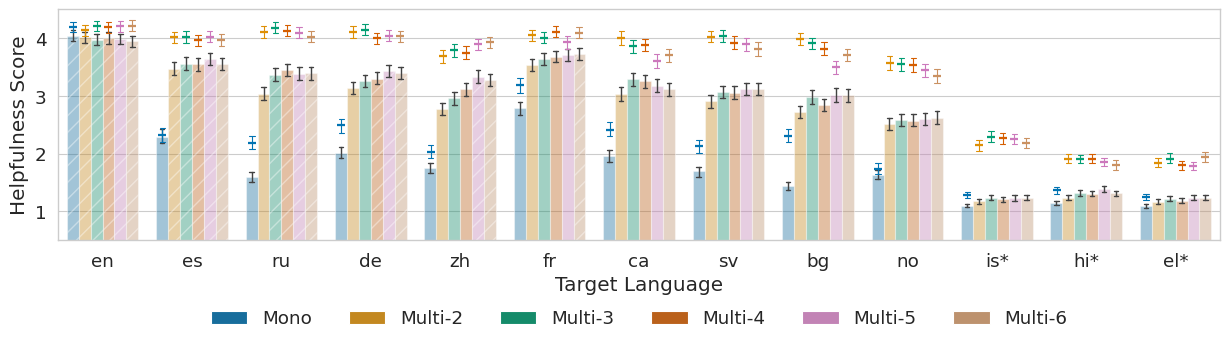

In [103]:
sdf1 = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 MT Multi-2', 'Llama-2 MT Multi-3', 'Llama-2 MT Multi-4', 'Llama-2 MT Multi-5', 'Llama-2 MT Multi-6'])]
sdf1 = sdf1[sdf1['test_set'].isin(ordered_alpaca_test_sets)]
sdf1 = sdf1[ (sdf1['eval_src'] == 'source') & (sdf1['eval_tgt'] == 'system') ]
sdf1['model_name'] = sdf1['model_name'].str.replace('Llama-2', '').str.replace('MT', '').str.strip()
print(len(sdf1))
sdf2 = df[df['model_name'].isin(['Llama-2 70B Mono', 'Llama-2 70B MT Multi-2', 'Llama-2 70B MT Multi-3', 'Llama-2 70B MT Multi-4', 'Llama-2 70B MT Multi-5', 'Llama-2 70B MT Multi-6'])]
sdf2 = sdf2[sdf2['test_set'].isin(ordered_alpaca_test_sets)]
sdf2 = sdf2[ (sdf2['eval_src'] == 'source') & (sdf2['eval_tgt'] == 'system') ]
sdf2['model_name'] = sdf2['model_name'].str.replace('Llama-2 70B', '').str.replace('MT', '').str.strip()
print(len(sdf2))
print(sdf1.columns)
print(sdf2.columns)

plot_llm_judge_score_distribution_differences(
    sdf1,
    sdf2, 
    # title='Llama-7b Evaluation (evaluated in x)',
    save_path='data/plots/chat_llm_judge_llama_7b_incremental_diff_70b.png'
    )

In [101]:
# import numpy as np
# import scipy.stats as stats

# # Function to calculate mean and confidence interval
# def mean_confidence_interval(data, confidence=0.95):
#     mean = np.mean(data)
#     se = stats.sem(data)
#     h = se * stats.t.ppf((1 + confidence) / 2., len(data)-1)
#     return mean, mean-h, mean+h

# mean_confidence_interval(sdf1)


# # def plot_difference_scores_with_ci(df, model1, model2):
    
# #     # Group data and apply the function
# #     grouped = df.groupby(['test_set', 'model_name']).eval_score.apply(lambda x: mean_confidence_interval(x, 0.95)).unstack()

# #     # Calculate differences and confidence intervals
# #     diff = (grouped[model1] - grouped[model2]).apply(pd.Series)
# #     diff.columns = ['mean_diff', 'lower_ci', 'upper_ci']

# #     # Create a new DataFrame for plotting
# #     diff_df = diff.reset_index()

# #     # Plotting the differences with error bars
# #     fig, ax = plt.subplots(figsize=(15, 3))
# #     ax.bar(diff_df['test_set'], diff_df['mean_diff'], yerr=[diff_df['mean_diff'] - diff_df['lower_ci'], diff_df['upper_ci'] - diff_df['mean_diff']],
# #            alpha=0.6, color='blue', capsize=5)

# #     # Adding a horizontal line at zero for reference
# #     ax.axhline(0, color='grey', linewidth=0.8)

# #     # Setting labels and title
# #     ax.set_ylabel('Difference in Eval Score with CI')
# #     ax.set_title('Difference in Evaluation Scores between {} and {} with 95% CI'.format(model1, model2))

# #     plt.show()

# # # Example usage
# # plot_difference_scores_with_ci(df, 'Model_A', 'Model_B')

ca     1800
bg     1800
no     1800
es     1799
zh     1799
el*    1799
de     1798
fr     1798
sv     1798
is*    1798
ru     1796
hi*    1788
en      899
Name: test_set, dtype: int64
saved to data/plots/chat_llm_judge_llama_7b_translated_vs_direct_eval.png


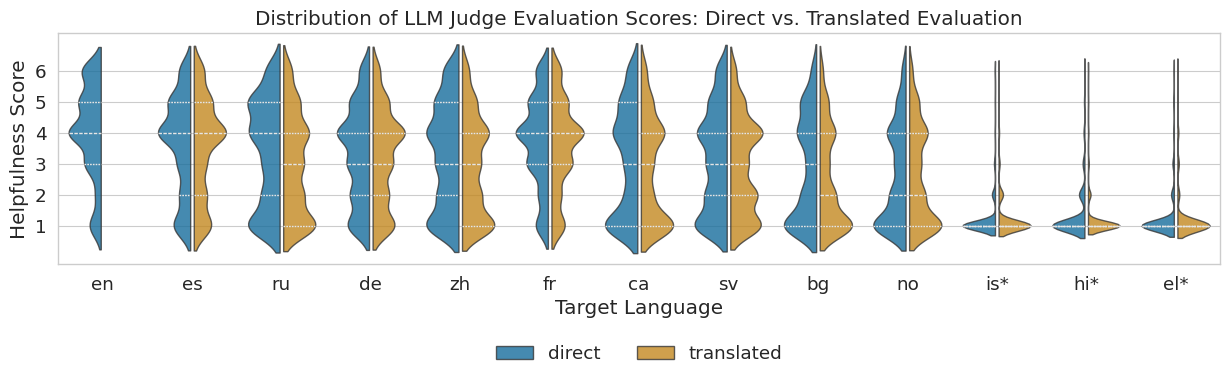

In [84]:

def plot_score_distribution_with_split_violins(df, title=None, save_path=None, hue='eval_type'):

    # for each test set, plot the distribution of eval_score for each model
    
    test_sets = [l for l in ordered_alpaca_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    
    fig, ax = plt.subplots(figsize=(15, 3))
    
    sns.violinplot(data=df, x='test_set', y='eval_score', hue=hue, ax=ax, 
                   fill=True, density_norm="count", common_norm=True,
                   split=True,
                   inner="quart",
                   dodge=True, gap=0.1,
                   alpha=0.8,
                   order=test_sets,
                #    inner_kws=dict(box_width=4, whis_width=1, color=".8"),
                   inner_kws=dict(color=".9"),
                   )
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Helpfulness Score')
    
    # set y-ticks to integers 1-6
    ax.set_yticks(range(1, 7))

    ax.set_title(title)

    # place legend outside of plot at bottom with 3 columns
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return

sdf = df[ (df['model_name'].isin(['Llama-2 Multi-6/ca'])) ]
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]

sdf['eval_type'] = sdf.apply(lambda x: "translated" if x['eval_src'] == 'source_en' else "direct", axis=1)

plot_score_distribution_with_split_violins(
    sdf, 
    title='Distribution of LLM Judge Evaluation Scores: Direct vs. Translated Evaluation',
    save_path='data/plots/chat_llm_judge_llama_7b_translated_vs_direct_eval.png'
    )

# for seed in [0, 42, 723]:
#     sdf = df[ (df['model_name'].isin(['Llama-2 Multi-6/ca'])) & (df['seed'] == seed) ] 
#     sdf = sdf[sdf['test_set'].isin(ordered_alpaca_test_sets)]

#     sdf['eval_type'] = sdf.apply(lambda x: "translated" if x['eval_src'] == 'source_en' else "direct", axis=1)

#     plot_score_distribution_with_split_violins(
#         sdf, 
#         title='Distribution of LLM Judge Evaluation Scores: Direct vs. Translated Evaluation',
#         save_path=f'data/plots/chat_llm_judge_llama_7b_s{seed}_translated_vs_direct_eval.png'
#         )

# translation results

In [ ]:
# translation results

# def get_mt_results(results_dir):
#     """
#     Collect all eval files in results_dir and parse them into a dataframe
#     """
#     dfs = []
#     for eval_file in sorted(Path(results_dir).glob('*/*.eval')):
#         # print(eval_file)
#         df = pd.read_csv(eval_file, index_col=None)
#         # print(eval_file)
#         model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(eval_file)
        
#         df['model_name'] = model_name
#         df['test_set'] = test_set
#         df['prompt'] = prompt
#         df['seed'] = seed
#         df['n_eval_items'] = n_eval_items
#         df['data_seed'] = data_seed
#         df['api_seed'] = api_seed
#         df['eval_src'] = eval_src
#         df['eval_tgt'] = eval_tgt

#         dfs.append(df)
            
#     # print(f'Gathered {len(dfs)} dataframes.')
#     df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

#     # # move input_file, model_name and seed to front
#     cols = df.columns.tolist()
#     cols.insert(0, cols.pop(cols.index('model_name')))
#     cols.insert(1, cols.pop(cols.index('test_set')))
#     cols.insert(2, cols.pop(cols.index('seed')))
#     cols.insert(3, cols.pop(cols.index('prompt')))
    
#     df = df.reindex(columns=cols)

#     return df

# df = get_mt_results('data/flores_outputs')

# # rename values according to name_map
# # TODO: fix Falcon Guanaco being mapped to nan
# df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

# df = apply_sort(df, ordered_test_sets=ordered_flores_test_sets)

# df['prompt_lang'] = df.apply(lambda x: 'xx' if x['prompt'].split('_')[-1] == x['test_set'][:2] else 'en' if x['prompt'].split('_')[-1] == 'en' else 'unk', axis=1)
# print(df['prompt_lang'].value_counts())

# print(df['model_name'].value_counts())
# df.head()

# # x = ['falcon_7b_ca_merged',
# # 'falcon_7b_de_merged',
# # 'llama_2_7b_hf_ru_merged',
# # 'llama_2_7b_hf_ml5_merged',
# # 'llama_2_7b_hf_ml3_merged',
# # 'llama_2_7b_hf_ml2_merged',
# # 'llama_2_7b_hf_ml1_merged',
# # 'llama_2_7b_hf_guanaco_merged',
# # 'llama_2_7b_hf_fr_merged',
# # 'llama_2_7b_hf_es_merged',
# # 'llama_2_7b_hf_de_merged',
# # 'llama_2_7b_hf_ca_merged',
# # 'falcon_7b_zh_merged',
# # 'falcon_7b_ru_merged',
# # 'falcon_7b_ml5_merged',
# # 'falcon_7b_ml4_merged',
# # 'falcon_7b_ml3_merged',
# # 'falcon_7b_ml2_merged',
# # 'falcon_7b_ml1_merged',
# # 'falcon_7b_guanaco_merged',
# # 'llama_2_7b_hf_zh_merged',
# # 'llama_2_7b_hf_ml4_merged',
# # ]
# # print([name_map[i] for i in x])



In [ ]:

# def plot_mt_score_distribution(df, metric='bleu', title=None, save_path=None):

#     # for each test set, plot the distribution of eval_score for each model
#     fig, ax = plt.subplots(figsize=(15, 3))
    
#     test_sets = [l for l in ordered_flores_test_sets if l in df['test_set'].unique()]
#     model_names = df['model_name'].unique()
    
#     # sns.boxplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
#     # sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
#     sns.barplot(data=df, x='test_set', y=metric, hue='model_name', ax=ax,  
#                 errorbar=("ci", 95), capsize=0.3,
#                 # errorbar='sd', capsize=0.3,
#                 err_kws={"linewidth": 1.0},
#                 alpha=1.0,
#                 order=test_sets,
#                 hue_order=model_names,
#                 )
    
#     # apply hatches to certain bars
#     # for p in ax.patches:
#     #     print(p)

#     # remove bars from sorted that correspond to the legend
#     bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

#     sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
#     # Create a dictionary to map each bar to its 'test_set' and 'model_name'
#     bar_info = {}
#     for i, test_set in enumerate(test_sets):
#         for j, model_name in enumerate(model_names):
#     #         # The index of the bar in the patches list
#             index = i * len(model_names) + j
#             bar_info[sorted_bars[index]] = {'test_set': test_set[:2], 'model_name': model_name}

#     # Loop over the bars and add a text label as a marker
#     for i, (bar, info) in enumerate(bar_info.items()):
#         if info['test_set'] in training_langs[info['model_name'].split()[-1]]:
#             bar.set_hatch('//')
#         else:
#             bar.set_hatch('')

    
#     ax.set_xlabel('Target Language')
#     if metric == 'bleu':
#         ax.set_ylabel(f'Avg. BLEU Score')
#         ax.set_ylim(0, 40)
#     elif metric == 'chrf':
#         ax.set_ylabel(f'Avg. ChrF++ Score')
    
#     ax.set_title(title)

#     # legend at bottom
#     if len(test_sets) >= 6:
#         ncols = len(model_names)
#         y_offset = -0.45
#     else:
#         ncols = 3
#         y_offset = -0.55
#     ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

#     if save_path:
#         fig.savefig(save_path, bbox_inches='tight', dpi=300)
#         print(f'saved to {save_path}')

#     return

# for metric in ['bleu', 'chrf']:
#     sdf = df[df['model_name'].isin(['Llama-2 Multi-6/es', 'Llama-2 Multi-6/ru', 'Llama-2 Multi-6/de', 'Llama-2 Multi-6/zh', 'Llama-2 Multi-6/fr', 'Llama-2 Multi-6/ca', 'Llama-2 Multi-Guanaco'])]
#     sdf['model_name'] = sdf['model_name'].str.replace('Llama-2', '').str.strip()
    
#     # usng en prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'en') ],
#         metric=metric, 
#         title='Llama-7b en --> xx (en prompt)',
#         save_path=f'data/plots/flores_mt_llama_7b_loo_wide_enprompt_{metric}.png'
#         )

#     # using x prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'xx') ],
#         metric=metric, 
#         title='Llama-7b en --> xx (xx prompt)',
#         save_path=f'data/plots/flores_mt_llama_7b_loo_wide_xprompt_{metric}.png'
#         )

In [ ]:
# for metric in ['bleu', 'chrf']:
#     sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6/ca', 'Llama-2 Multi-Guanaco'])]
#     sdf['model_name'] = sdf['model_name'].str.replace('Llama-2', '').str.replace('/ca', '').str.strip()

#     # usng en prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'en') ],
#         metric=metric, 
#         title='Llama-7b en --> xx (en prompt)',
#         save_path=f'data/plots/flores_mt_llama_7b_incremental_ml_wide_enprompt_{metric}.png'
#         )

#     # using x prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'xx') ],
#         metric=metric, 
#         title='Llama-7b en --> xx (xx prompt)',
#         save_path=f'data/plots/flores_mt_llama_7b_incremental_ml_wide_xprompt_{metric}.png'
#         )





In [ ]:
# for metric in ['bleu', 'chrf']:
#     sdf = df[df['model_name'].isin(['Falcon M6L/es', 'Falcon Multi-6/ru', 'Falcon Multi-6/de', 'Falcon Multi-6/zh', 'Falcon Multi-6/fr', 'Falcon Multi-6/ca', 'Falcon Multi-Guanaco'])]
#     sdf['model_name'] = sdf['model_name'].str.replace('Llama-2', '').str.strip()
    
#     # usng en prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'en') ],
#         metric=metric, 
#         title='Falcon-7b en --> xx (en prompt)',
#         save_path=f'data/plots/flores_mt_falcon_7b_loo_wide_enprompt_{metric}.png'
#         )

#     # using x prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'xx') ],
#         metric=metric, 
#         title='Falcon-7b en --> xx (xx prompt)',
#         save_path=f'data/plots/flores_mt_falcon_7b_loo_wide_xprompt_{metric}.png'
#         )
    
# for metric in ['bleu', 'chrf']:
#     sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6/ca', 'Falcon Multi-Guanaco'])]
#     sdf['model_name'] = sdf['model_name'].str.replace('Falcon', '').str.replace('/ca', '').str.strip()
    

#     # usng en prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'en') ],
#         metric=metric, 
#         title='Falcon-7b en --> xx (en prompt)',
#         save_path=f'data/plots/flores_mt_falcon_7b_incremental_ml_wide_enprompt_{metric}.png'
#         )

#     # using x prompt
#     plot_mt_score_distribution(
#         sdf[ (sdf['prompt_lang'] == 'xx') ],
#         metric=metric, 
#         title='Falcon-7b en --> xx (xx prompt)',
#         save_path=f'data/plots/flores_mt_falcon_7b_incremental_ml_wide_xprompt_{metric}.png'
#         )


# XCSQA results

In [ ]:
# XCSQA

def get_xcsqa_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for output_file in sorted(Path(results_dir).glob('*/*.jsonl')):
        df = pd.read_json(output_file, lines=True)
        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(output_file)
        
        df['model_name'] = model_name
        df['test_set'] = test_set

        if prompt == 'blank':
            dataset, split, prompt_lang, tgt_lang = test_set.split('_')
            if prompt_lang == 'en':
                prompt = 'en'
            else:
                prompt = 'X'
                
        df['prompt'] = prompt
        df['seed'] = seed

        dfs.append(df)
            
    df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('prompt')))
    
    df = df.reindex(columns=cols)

    return df

df = get_xcsqa_results('data/xcsqa_outputs/')

# rename values according to name_map
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

df = apply_sort(df, ordered_test_sets=ordered_xcsr_test_sets)

# compute scores for each item
df['score'] = df.apply(lambda x: 1 if x['system'][0].lower() == x['reference'][0].lower() else 0, axis=1)

print(df['score'].value_counts())
print(df['test_set'].value_counts())
print(df['model_name'].value_counts())

df.head()

In [ ]:
# plot score distribution
def plot_xcsqa_score_distribution(df, title=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 3))
    
    test_sets = [l for l in ordered_xcsr_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(test_sets)
    print(model_names)
    # sns.boxplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    # sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    sns.barplot(data=df, x='test_set', y='score', hue='model_name', ax=ax,  
                errorbar=('ci', 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                )
        
    # apply hatches to certain bars
    # for p in ax.patches:
    #     print(p)

    # remove bars from sorted that correspond to the legend
    bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    bar_info = {}
    for i, test_set in enumerate(test_sets):
        for j, model_name in enumerate(model_names):
    #         # The index of the bar in the patches list
            index = i * len(model_names) + j
            bar_info[sorted_bars[index]] = {'test_set': test_set.split(':')[-1][:2], 'model_name': model_name}

    # Loop over the bars and add a text label as a marker
    for i, (bar, info) in enumerate(bar_info.items()):
        if info['test_set'] in training_langs[info['model_name'].split()[-1]]:
            bar.set_hatch('//')
        else:
            bar.set_hatch('')
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Accuracy')
    
    ax.set_title(title)

    # legend at bottom
    if len(test_sets) >= 6:
        ncols = len(model_names)
        y_offset = -0.45
    else:
        ncols = 3
        y_offset = -0.55
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return


# sdf = df[df['model_name'].isin(['Llama-2 Multi-6/de', 'Llama-2 Multi-6/es', 'Llama-2 Multi-6/ru', 'Llama-2 Multi-6/fr'])]
# print(sdf['test_set'].value_counts())
# sdf = sdf[sdf['test_set'].isin(ordered_xcsr_test_sets)]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')

# plot_xcsqa_score_distribution(
#     sdf, 
#     # title='Llama-7b X-CSQA',
#     save_path='data/plots/xcsqa_llama_7b_loo.png'
#     )

sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6/ca', 'Llama-2 Multi-Guanaco'])]
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_xcsr_test_sets)]
sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '').str.strip()

plot_xcsqa_score_distribution(
    sdf, 
    # title='Llama-7b X-CSQA',
    save_path='data/plots/xcsqa_llama_7b_incremental.png'
    )

sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6/ca', 'Falcon Multi-Guanaco'])]
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_xcsr_test_sets)]
sdf['model_name'] = sdf['model_name'].str.replace('Falcon', '').str.replace('/ca', '').str.strip()

plot_xcsqa_score_distribution(
    sdf, 
    # title='Falcon-7b X-CSQA',
    save_path='data/plots/xcsqa_falcon_7b_incremental.png'
    )

In [ ]:
df[df['model_name'] == 'Falcon Mono']

In [ ]:
# XQuAD
import re

def postprocess_system_response(system, source):
    """
    Strip away trailing text after the first closing quotation mark
    """

    # special handling for de and ru: extract question from source
    question_string = re.search(r"\n\n(Frage|Вопрос):\n\n(.*?)\n\n", source)
    if question_string:
        question_string = question_string.group(2)
        # if question is in system response, remove it
        if system.startswith(question_string):
            text = system[len(question_string):]
            # split text on first full stop or line break
            text = re.split(r'[\.\n]', text)[0].strip()[:50]
            return text

    # vietnamese responses frequently contain opening and closing quotes
    if system and system[0] in ['"', '“', '”', '«', '„']:
        system = system[1:].strip()

    # vietnamese responses often start with a colon and newline
    if system and system[0] in [':']:
        system = system[1:].strip()

    match = re.match(r'(.*?)["”“»]', system)
    if match:
        text = match.group(1)
        text = re.split(r'[\.\n]', text)[0].strip()[:50]
    else:
        text = ''

    return text

def compute_xquad_score(text, reference):
    """
    Check whether the text answer matches the reference answer
    """

    # normalize punctuation
    reference = reference.replace('’', "'").replace('‘', "'").replace('”', '"').replace('“', '"').replace('«', '"').replace('»', '"').replace('–', '-').replace('—', '-').replace('…', '...')

    if reference == text:
        return 1
    elif reference in text:
        return 1
    else:
        return 0

def get_xquad_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for output_file in sorted(Path(results_dir).glob('*/*.jsonl')):
        df = pd.read_json(output_file, lines=True)
        model_name, test_set, prompt, seed, has_translation, n_eval_items, data_seed, api_seed, eval_src, eval_tgt = parse_filename(output_file)
        
        df['model_name'] = model_name
        df['test_set'] = test_set

        if prompt == 'blank':
            dataset, split, prompt_lang, tgt_lang = test_set.split('_')
            if prompt_lang == 'en':
                prompt = 'en'
            else:
                prompt = 'X'
                
        df['prompt'] = prompt
        df['seed'] = seed

        dfs.append(df)
            
    df = pd.concat(dfs, axis=0, ignore_index=False, join='outer').reset_index(drop=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    cols.insert(3, cols.pop(cols.index('prompt')))
    
    df = df.reindex(columns=cols)

    return df

df = get_xquad_results('data/xquad_outputs/')

# rename values according to name_map
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)

df = apply_sort(df, ordered_test_sets=ordered_xquad_test_sets)

print(df['test_set'].value_counts())
print(df['model_name'].value_counts())

df['system'] = df.apply(lambda x: postprocess_system_response(x['system'], x['source']), axis=1)

# drop 'source' column
df = df.drop(columns=['source'])

df['score'] = df.apply(lambda x: compute_xquad_score(x['system'].lower(), x['reference'].lower()), axis=1)


print(df['score'].value_counts())
df.head(30)

In [ ]:
# plot score distribution
def plot_xquad_score_distribution(df, title=None, save_path=None):

    # for each test set, plot the distribution of eval_score for each model
    fig, ax = plt.subplots(figsize=(15, 3))
    
    test_sets = [l for l in ordered_xquad_test_sets if l in df['test_set'].unique()]
    model_names = df['model_name'].unique()
    print(test_sets)
    print(model_names)
    # sns.boxplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    # sns.barplot(data=df, x='test_set', y='eval_score', hue='model_name', ax=ax)
    sns.barplot(data=df, x='test_set', y='score', hue='model_name', ax=ax,  
                errorbar=('ci', 95), capsize=0.3,
                err_kws={"linewidth": 1.0},
                alpha=1.0,
                order=test_sets,
                hue_order=model_names,
                )
        
    # # apply hatches to certain bars
    # # for p in ax.patches:
    # #     print(p)

    # # remove bars from sorted that correspond to the legend
    # bars = [patch for patch in ax.patches if patch.xy != (0, 0)]

    # sorted_bars = sorted(bars, key=lambda bar: bar.get_x(), reverse=False)
    
    # # Create a dictionary to map each bar to its 'test_set' and 'model_name'
    # bar_info = {}
    # for i, test_set in enumerate(test_sets):
    #     for j, model_name in enumerate(model_names):
    # #         # The index of the bar in the patches list
    #         index = i * len(model_names) + j
    #         bar_info[sorted_bars[index]] = {'test_set': test_set.split(':')[-1][:2], 'model_name': model_name}

    # # Loop over the bars and add a text label as a marker
    # for i, (bar, info) in enumerate(bar_info.items()):
    #     if info['test_set'] in training_langs[info['model_name'].split()[-1]]:
    #         bar.set_hatch('//')
    #     else:
    #         bar.set_hatch('')
    
    ax.set_xlabel('Target Language')
    ax.set_ylabel('Accuracy')
    
    ax.set_title(title)

    # legend at bottom
    if len(test_sets) >= 6:
        ncols = len(model_names)
        y_offset = -0.45
    else:
        ncols = 3
        y_offset = -0.55
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, y_offset), ncol=ncols, frameon=False)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'saved to {save_path}')

    return

# sdf = df[df['model_name'].isin(['Llama-2 Multi-6/de', 'Llama-2 Multi-6/es', 'Llama-2 Multi-6/ru', 'Llama-2 Multi-6/zh'])]
# print(sdf['test_set'].value_counts())
# sdf = sdf[sdf['test_set'].isin(ordered_xquad_test_sets)]
# sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '')

# plot_xquad_score_distribution(
#     sdf, 
#     # title='Llama-7b X-QuAD',
#     save_path='data/plots/xquad_llama_7b_loo.png'
#     )

sdf = df[df['model_name'].isin(['Llama-2 Mono', 'Llama-2 Multi-2', 'Llama-2 Multi-3', 'Llama-2 Multi-4', 'Llama-2 Multi-5', 'Llama-2 Multi-6/ca', 'Llama-2 Multi-Guanaco'])]
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_xquad_test_sets)]
# remove ar
sdf = sdf[~sdf['test_set'].str.contains('ar')]

sdf['model_name'] = sdf['model_name'].str.replace('Llama-2 ', '').str.replace('/ca', '').str.strip()

plot_xquad_score_distribution(
    sdf, 
    # title='Llama-7b X-QuAD',
    save_path='data/plots/xquad_llama_7b_incremental.png'
    )

In [ ]:
sdf = df[df['model_name'].isin(['Falcon Mono', 'Falcon Multi-2', 'Falcon Multi-3', 'Falcon Multi-4', 'Falcon Multi-5', 'Falcon Multi-6/ca', 'Falcon Multi-Guanaco'])]
print(sdf['test_set'].value_counts())
sdf = sdf[sdf['test_set'].isin(ordered_xquad_test_sets)]
sdf['model_name'] = sdf['model_name'].str.replace('Falcon ', '').str.replace('/ca', '').str.strip()
# remove arabic
sdf = sdf[~sdf['test_set'].str.contains('ar')]

plot_xquad_score_distribution(
    sdf, 
    # title='Llama-7b X-QuAD',
    save_path='data/plots/xquad_falcon_7b_incremental.png'
    )

In [ ]:
df[df['test_set'] == 'en:tr*']

In [ ]:
# get length of longest reference
df['reference_len'] = df.apply(lambda x: len(x['reference']), axis=1)
df['reference_len'].describe()

In [ ]:
df[df['reference_len'] == 206]

In [ ]:
# def plot_grouped_bars(df, group_column):
#     """
#     Takes a pandas dataframe and a column name as the grouping variable.
#     Initialises a matplotlib figure and axis object and plots data as bar plots.
    
#     Args:
#     df (pd.DataFrame): The pandas dataframe containing the data.
#     group_column (str): The column name to group the data by.
    
#     Returns:
#     matplotlib figure and axis with the bar plot.
#     """
    
#     # Initialize the matplotlib figure and axis object
#     fig, ax = plt.subplots()
    
#     # Unique categories in the grouping variable
#     test_sets = [name for name in ordered_test_sets if name in df['test_set'].unique()]
#     models = test_set_data['model_name'].unique()

#     # expected number of bars
#     expected_num_bars = len(test_sets) * len(models)

#     x_ticks = np.arange(len(expected_num_bars))  # the label locations
#     print(x_ticks)

#     width = 0.1  # the width of the bars
#     multiplier = 0

#     for i, test_set in enumerate(test_sets):
#         # print(i, test_set)
#         # Filter the dataframe for the current category
#         test_set_data = df[df['test_set'] == test_set]

#         models = test_set_data['model_name'].unique()

#         for j, model in enumerate(models):
            
#             model_data = test_set_data[test_set_data['model_name'] == model]
            
#             scores_translated = model_data[ (model_data['eval_src'] == 'source_en') & (model_data['eval_tgt'] == 'system_en') ]['eval_score']
#             scores_untranslated = model_data[ (model_data['eval_src'] == 'source') & (model_data['eval_tgt'] == 'system') ]['eval_score']
    
#             # get average score for each model
#             scores_translated_mean = scores_translated.mean()
#             scores_untranslated_mean = scores_untranslated.mean()

#             # get standard error for each model
#             scores_translated_std = scores_translated.std()
#             scores_untranslated_std = scores_untranslated.std()

#             print(scores_translated_mean, scores_translated_std)
#             print(scores_untranslated_mean, scores_untranslated_std)
            
            
#             # plot translated scores and untranslated scores side by side
#             ax.bar(x_pos, scores_translated_mean, yerr=scores_translated_std, width=width, label=f'{model} tr', hatch='//')
#             # ax.bar(x_ticks[i] + width * multiplier + width, scores_untranslated_mean, yerr=scores_untranslated_std, width=width, label=model, hatch='')

#             multiplier += 1

#             # offset = width * multiplier
#             # print((x + offset))

#             # score_translated = ax.bar((x + offset), [scores_translated_mean], yerr=[scores_translated_std], width=width/0.5, label=model, hatch='//')
#             # print((x + offset))
#             # scores_untranslated = ax.bar((x + offset)+width/0.5, [scores_untranslated_mean], yerr=[scores_untranslated_std], width=width/0.5, label=model, hatch='')
#             # multiplier += 1
#             # ax.bar([test_set]+offset, [scores_translated_mean], yerr=[scores_translated_std], label=model, hatch='//')
#             # ax.bar([test_set]+offset, [scores_untranslated_mean], yerr=[scores_untranslated_std], label=model, hatch='')
#             # offset += 0.2
#             # ax.bar(x=model, height=scores_translated_mean, yerr=scores_translated_std, label='translated', alpha=0.5)
#         #         # The next bar plot should start on top of the previous one, so we update 'bottom'
#         # if bottom is None:
#         #     bottom = summary_data
#         # else:
#         #     bottom = bottom + summary_data
    
#     # set xtick labels as test sets
#     ax.set_xticks(x_ticks)
#     ax.set_xticklabels(test_sets)

#     # Add legend, labels and title
#     ax.legend(title=group_column)
#     ax.set_ylabel("Values")
#     ax.set_title("Grouped Bar Plot")
    
#     # place legend outside of plot at bottom with 3 columns
#     ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3)
    
#     return fig, ax

# plot_grouped_bars(df[df['test_set'].isin(['en','de'])], 'test_set') 

In [ ]:
def get_generations(results_dir):
    dfs = []
    for generations_file in Path(results_dir).glob('*/*.llm_eval'):
        # print(eval_file)
        df = pd.read_json(generations_file, lines=True)
        model_name, test_set, prompt, seed = parse_filename(generations_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
    df = pd.concat(dfs, axis=0, ignore_index=False)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    # cols.insert(0, df.ndex)
    df = df.reindex(columns=cols)

    return df

gen_df = get_generations(results_dir)

gen_df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)
print(len(gen_df))
print(gen_df.columns)
gen_df.head()

# data/outputs/llama_2_7b_hf_zh_merged/alpaca_eval_instructions_zh-none-guanaco_prompt-s42-k50-p0.9-t0.8-b8-gpt_3.5_turbo-l50.llm_eval

In [ ]:
gen_df['model_name_test_set'] = gen_df['model_name'] + ' ' + gen_df['test_set']

In [ ]:
def calculate_legend_bbox(subplot_height, figsize_height, margin_fraction=0.1):
    # Calculate the margin as a fraction of the subplot height
    margin = margin_fraction * subplot_height

    # Calculate the bbox_to_anchor value
    bbox_to_anchor = (0.5, -margin / figsize_height)

    return bbox_to_anchor

def calculate_figure_height(num_items, target_aspect_ratio):
    # Calculate the width of the figure based on the target aspect ratio
    fig_width = 6
    fig_height = fig_width / target_aspect_ratio

    # Calculate the subplot height based on the number of items
    subplot_height = fig_height / num_items

    return fig_width, fig_height, subplot_height

# plot the judgemtnts for each model
def plot_judgements(df, judge='GPT-3.5-Turbo', title=None, task_id='', output_dir=None, target_aspect_ratio=1.5, margin_fraction=0.5):
    """
    
    """
    
    # models = df['model_name'].unique().tolist()[::-1]
    test_sets = df['model_name_test_set'].unique().tolist()[::-1]

    # Calculate the figure width, height, and subplot height
    fig_width, fig_height, subplot_height = calculate_figure_height(len(test_sets), target_aspect_ratio=target_aspect_ratio)
    print(f'fig_width: {fig_width}, fig_height: {fig_height}, subplot_height: {subplot_height}')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_width, fig_height), sharey=True, sharex=True, dpi=200, tight_layout=True)

    colors = {'Excellent': '#0068FF', 'Pass': '#2B96FF', 'Fail': '#ABD2FF'}

    # for i, model in enumerate(models):
        # print(model)
    for j, test_set in enumerate(test_sets):
        # print(test_set)
        # sdf = df[(df['model_name'] == model) & (df['test_set'] == test_set)]
        sdf = df[df['model_name_test_set'] == test_set]
        # print(len(sdf))
        # print(sdf.columns)
        if judge == 'GPT-3.5-Turbo':
            results = sdf['gpt-3.5-turbo-judgement'].value_counts(normalize=True).to_dict()
        elif judge == 'GPT-4':
            results = sdf['gpt-4-judgement'].value_counts(normalize=True).to_dict()
        else:
            raise ValueError(f'Unknown judge: {judge}')
        
        # sort order: 'Excellent, Pass, Fail'
        results = {k: results.get(k, 0.0) for k in ['Excellent', 'Pass', 'Fail']}
        # multiply by 100 to get percentage
        results = {k: v * 100 for k, v in results.items()}

        print(f'{test_set}: {results}')

        prev_val = 0
        for k, v in results.items():

            ax.barh(y=j, width=v, height=0.8, left=prev_val, 
                    color=colors[k], alpha=0.8, # set the color of each bar individually
                    label=k if j == 0 else "", # label the first bar in each stack with the model name
                    )
            
            # label bar with value
            if v > 1:
                ax.text(x=prev_val + v/2, y=j, s=f'{v:.1f}%', ha='center', va='center', fontsize=4)

            # add the value of each bar to the previous value
            prev_val += v
    
            # # hide legend for all but the first model
            # if i == 0 and j > 0:
            #     ax.get_legend().remove()


    # Set the y-ticks to be the model names
    ax.set_yticks(np.arange(len(test_sets)), test_sets, fontsize=6)
    ax.set_xlabel('')

    ax.set_xticks([0, 25, 50, 75, 100], ['0%', '25%', '50%', '75%', '100%'], minor=False)
    # ax.set_xticklabels()

    # remove x-axis ticks
    # ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    # # put the legend out of the plot and center it
    # # if len(models) > 2:
    # bbox_to_anchor = calculate_legend_bbox(subplot_height, fig_height, margin_fraction=margin_fraction)
    # print(bbox_to_anchor)
    # ax.legend(bbox_to_anchor=bbox_to_anchor, loc='lower center', ncol=3, frameon=False)# , fontsize=8)
    # # else:
    # #     ax.legend(bbox_to_anchor=(0.5, -0.2), loc='lower center', ncol=3, frameon=False, fontsize=8)

    # Adjust the margins
    plt.margins(y=0.05, x=0.0)

    # title of plot
    if not title:
        ax.set_title(f'{task_id}\nDA with {judge} as Judge')
    else:
        ax.set_title(title)

    if output_dir is not None:
        outfile = Path(output_dir) / f'da_judge_{judge}-{task_id}.png'
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
        print(f'Saved to {outfile}')

    return

plot_judgements(gen_df, judge='GPT-3.5-Turbo')

In [ ]:
plot_judgements(gen_df, judge='GPT-4')


In [ ]:
gen_df['gpt-4-justification'].value_counts()

In [ ]:
gen_df['gpt-3.5-turbo-justification'].value_counts()

In [ ]:
# inspect off-target generations in output files

def get_generations(results_dir):
    dfs = []
    for generations_file in Path(results_dir).glob('*/*.jsonl'):
        # print(eval_file)
        df = pd.read_json(generations_file, lines=True)
        model_name, test_set, prompt, seed = parse_filename(generations_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
    df = pd.concat(dfs, axis=0, ignore_index=False)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    # cols.insert(0, df.ndex)
    df = df.reindex(columns=cols)

    return df

gen_df = get_generations(results_dir)
gen_df